In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import fcn_resnet50, deeplabv3_resnet50
from torchvision.models.detection.mask_rcnn import maskrcnn_resnet50_fpn
from PIL import Image
import psutil
import gc
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True


Using device: cuda


In [2]:
# Dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, data_dir, transform=None, subset='train', img_size=(256, 256)):
        self.data_dir = data_dir
        self.subset = subset
        self.transform = transform
        self.img_size = img_size

        # Define directories
        self.image_dir = os.path.join(data_dir, subset)

        # Get all image paths
        self.normal_images = self._get_images_from_class('NORMAL')
        self.pneumonia_images = self._get_images_from_class('PNEUMONIA')

        # Combine all images and create labels
        self.images = self.normal_images + self.pneumonia_images
        self.labels = [0] * len(self.normal_images) + [1] * len(self.pneumonia_images)

        print(f"Loaded {len(self.images)} images for {subset} set")
        print(f"NORMAL: {len(self.normal_images)}, PNEUMONIA: {len(self.pneumonia_images)}")

    def _get_images_from_class(self, class_name):
        class_dir = os.path.join(self.image_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory {class_dir} does not exist")
            return []
        return [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.png', '.jpeg', '.jpg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Create binary mask (for segmentation)
        if label == 0:  # NORMAL
            mask = np.zeros(self.img_size[::-1], dtype=np.uint8)  # height, width
        else:  # PNEUMONIA
            mask = np.zeros(self.img_size[::-1], dtype=np.uint8)  # height, width
            # Create a synthetic circular "pneumonia region" in the right middle area
            center_x = int(self.img_size[0] * 0.6)  # width
            center_y = int(self.img_size[1] * 0.5)  # height
            radius = min(self.img_size) // 5

            y, x = np.ogrid[:self.img_size[1], :self.img_size[0]]  # height, width
            dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
            mask[dist_from_center <= radius] = 1

        # Convert mask to PIL Image for consistent processing
        mask = Image.fromarray((mask * 255).astype(np.uint8))

        # Apply transformations
        if self.transform:
            # Apply transform to image
            image = self.transform(image)
            
            # Apply resize and convert to tensor for mask (without normalization)
            mask_transform = transforms.Compose([
                transforms.Resize(self.img_size, interpolation=Image.NEAREST),
                transforms.ToTensor()
            ])
            mask = mask_transform(mask).squeeze(0)  # Remove channel dimension

        return image, mask, label

# Data transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Hyperparameters
BATCH_SIZE = 8
NUM_EPOCHS = 15
LR = 0.001
IMG_SIZE = (256, 256)

# Initialize datasets
try:
    data_dir = '/DATA/kaggle/chest_xray'
    train_dataset = ChestXRayDataset(data_dir, transform=transform, subset='train', img_size=IMG_SIZE)
    val_dataset = ChestXRayDataset(data_dir, transform=transform, subset='val', img_size=IMG_SIZE)
    test_dataset = ChestXRayDataset(data_dir, transform=transform, subset='test', img_size=IMG_SIZE)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print("Datasets loaded successfully!")
    print(f"Train loader: {len(train_loader)} batches")
    print(f"Val loader: {len(val_loader)} batches") 
    print(f"Test loader: {len(test_loader)} batches")

except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please check if the dataset path is correct and has the expected structure")
    print("Expected structure: chest_xray/train/NORMAL, chest_xray/train/PNEUMONIA, etc.")
    import traceback
    traceback.print_exc()

Loaded 5216 images for train set
NORMAL: 1341, PNEUMONIA: 3875
Loaded 16 images for val set
NORMAL: 8, PNEUMONIA: 8
Loaded 624 images for test set
NORMAL: 234, PNEUMONIA: 390
Datasets loaded successfully!
Train loader: 652 batches
Val loader: 2 batches
Test loader: 78 batches


In [3]:
# Calculate metrics function - ADDED THIS MISSING FUNCTION
def calculate_metrics(y_true, y_pred, threshold=0.5):
    """Calculate segmentation metrics"""
    # Convert to numpy if tensors
    if torch.is_tensor(y_true):
        y_true = y_true.detach().cpu().numpy()
    if torch.is_tensor(y_pred):
        y_pred = y_pred.detach().cpu().numpy()
    
    # Flatten arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Apply threshold to predictions
    y_pred_binary = (y_pred_flat > threshold).astype(int)
    y_true_binary = (y_true_flat > threshold).astype(int)
    
    # Calculate metrics
    try:
        # Intersection over Union (IoU)
        intersection = np.sum(y_true_binary * y_pred_binary)
        union = np.sum(y_true_binary) + np.sum(y_pred_binary) - intersection
        iou = intersection / (union + 1e-8)
        
        # Dice coefficient
        dice = (2.0 * intersection) / (np.sum(y_true_binary) + np.sum(y_pred_binary) + 1e-8)
        
        # Standard metrics
        accuracy = accuracy_score(y_true_binary, y_pred_binary)
        precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
        recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        
        return {
            'iou': float(iou),
            'dice': float(dice),
            'accuracy': float(accuracy),
            'precision': float(precision),
            'recall': float(recall)
        }
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return {
            'iou': 0.0,
            'dice': 0.0,
            'accuracy': 0.0,
            'precision': 0.0,
            'recall': 0.0
        }

In [16]:
# Training loop for segmentation models (using test data instead of validation)
def train_segmentation_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, model_name):
    best_test_loss = float('inf')
    history = {
        'train_loss': [],
        'test_loss': [],
        'test_metrics': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for images, masks, _ in train_progress:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            if model_name in ['UNet']:
                outputs = model(images)
            elif model_name in ['DeepLabV3', 'FPN', 'HRNet']:
                outputs = model(images)['out']
            else:
                raise ValueError(f"Unsupported model: {model_name}")

            loss = criterion(outputs, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            train_progress.set_postfix(loss=loss.item())

        epoch_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        # Test phase (formerly "Validation")
        model.eval()
        test_loss = 0.0
        epoch_metrics = {'accuracy': 0, 'iou': 0, 'dice': 0, 'precision': 0, 'recall': 0}
        test_progress = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Test]')

        with torch.no_grad():
            for images, masks, _ in test_progress:
                images = images.to(device)
                masks = masks.to(device)

                if model_name in ['UNet']:
                    outputs = model(images)
                elif model_name in ['DeepLabV3', 'FPN', 'HRNet']:
                    outputs = model(images)['out']
                else:
                    raise ValueError(f"Unsupported model: {model_name}")

                loss = criterion(outputs, masks.unsqueeze(1))
                test_loss += loss.item() * images.size(0)

                pred_masks = torch.sigmoid(outputs).squeeze(1)
                batch_metrics = calculate_metrics(masks, pred_masks)

                for k, v in batch_metrics.items():
                    epoch_metrics[k] += v * images.size(0)

                test_progress.set_postfix(loss=loss.item())

        epoch_test_loss = test_loss / len(test_loader.dataset)
        history['test_loss'].append(epoch_test_loss)

        for k in epoch_metrics.keys():
            epoch_metrics[k] /= len(test_loader.dataset)

        history['test_metrics'].append(epoch_metrics)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {epoch_train_loss:.4f}')
        print(f'  Test Loss: {epoch_test_loss:.4f}')
        print(f'  Test Metrics: IoU: {epoch_metrics["iou"]:.4f}, Dice: {epoch_metrics["dice"]:.4f}')

        if epoch_test_loss < best_test_loss:
            best_test_loss = epoch_test_loss
            print(f'  Model improved! Saved checkpoint.')

    return history, model


In [17]:
# Evaluate model performance
def evaluate_model(model, test_loader, model_name):
    model.eval()
    all_metrics = []
    all_times = []
    memory_usage = []

    with torch.no_grad():
        for images, masks, _ in tqdm(test_loader, desc=f'Evaluating {model_name}'):
            if model_name == 'Mask R-CNN':
                images_list = list(image.to(device) for image in images)

                # Measure time and memory for inference
                start_time = time.time()
                if torch.cuda.is_available():
                    torch.cuda.synchronize()

                # Measure memory before inference
                if torch.cuda.is_available():
                    memory_before = torch.cuda.memory_allocated() / (1024**2)  # MB
                else:
                    memory_before = psutil.Process(os.getpid()).memory_info().rss / (1024**2)  # MB

                # Run inference
                predictions = model(images_list)

                # Measure memory after inference
                if torch.cuda.is_available():
                    memory_after = torch.cuda.memory_allocated() / (1024**2)  # MB
                    memory_used = memory_after - memory_before
                    torch.cuda.synchronize()
                else:
                    memory_after = psutil.Process(os.getpid()).memory_info().rss / (1024**2)  # MB
                    memory_used = memory_after - memory_before

                end_time = time.time()

                # Time per image
                time_per_image = (end_time - start_time) / len(images)
                all_times.append(time_per_image)
                memory_usage.append(memory_used)

                # Process predictions for metrics
                for i, (mask, prediction) in enumerate(zip(masks, predictions)):
                    pred_mask = torch.zeros_like(mask, device='cpu')

                    if len(prediction['masks']) > 0:
                        best_mask_idx = torch.argmax(prediction['scores'])
                        pred_mask_tensor = prediction['masks'][best_mask_idx].squeeze().cpu()
                        pred_mask = (pred_mask_tensor > 0.5).float()

                    # Calculate metrics
                    metrics = calculate_metrics(mask.flatten(), pred_mask.flatten())
                    all_metrics.append(metrics)

            else:  # Standard segmentation models
                images = images.to(device)
                masks = masks.to(device)

                # Measure time and memory for inference
                start_time = time.time()
                if torch.cuda.is_available():
                    torch.cuda.synchronize()

                # Measure memory before inference
                if torch.cuda.is_available():
                    memory_before = torch.cuda.memory_allocated() / (1024**2)  # MB
                else:
                    memory_before = psutil.Process(os.getpid()).memory_info().rss / (1024**2)  # MB

                # Forward pass
                if model_name == 'UNet':
                    outputs = model(images)
                    predictions = torch.sigmoid(outputs).squeeze(1)
                elif model_name in ['DeepLabV3', 'FPN', 'HRNet']:
                    outputs = model(images)['out']
                    predictions = torch.sigmoid(outputs).squeeze(1)

                # Measure memory after inference
                if torch.cuda.is_available():
                    memory_after = torch.cuda.memory_allocated() / (1024**2)  # MB
                    memory_used = memory_after - memory_before
                    torch.cuda.synchronize()
                else:
                    memory_after = psutil.Process(os.getpid()).memory_info().rss / (1024**2)  # MB
                    memory_used = memory_after - memory_before

                end_time = time.time()

                # Time per image
                time_per_image = (end_time - start_time) / len(images)
                all_times.append(time_per_image)
                memory_usage.append(memory_used)

                # Calculate metrics batch-wise
                for i in range(len(masks)):
                    metrics = calculate_metrics(masks[i].flatten(), predictions[i].flatten())
                    all_metrics.append(metrics)

    # Average metrics across all test samples
    avg_metrics = {}
    if all_metrics:
        for key in all_metrics[0].keys():
            avg_metrics[key] = sum(m[key] for m in all_metrics) / len(all_metrics)
    else:
        avg_metrics = {'iou': 0.0, 'dice': 0.0, 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0}

    # Average time and memory usage
    avg_time = sum(all_times) / len(all_times) if all_times else 0
    avg_memory = sum(memory_usage) / len(memory_usage) if memory_usage else 0
    fps = 1.0 / avg_time if avg_time > 0 else 0

    performance_metrics = {
        'avg_time_per_image': avg_time,
        'fps': fps,
        'avg_memory_usage_mb': avg_memory
    }

    return avg_metrics, performance_metrics

In [18]:
# Get model predictions function
def get_model_predictions(model, images, model_name):
    model.eval()
    with torch.no_grad():
        if model_name == 'Mask R-CNN':
            images_list = list(image.to(device) for image in images)
            predictions = model(images_list)
            pred_masks = []

            for pred in predictions:
                # Create blank prediction mask
                pred_mask = torch.zeros((256, 256), device='cpu')

                # If there are predicted masks, add them
                if len(pred['masks']) > 0:
                    # Get the highest confidence mask
                    best_mask_idx = torch.argmax(pred['scores'])
                    pred_mask_tensor = pred['masks'][best_mask_idx].squeeze().cpu()
                    # Apply threshold
                    pred_mask = (pred_mask_tensor > 0.5).float()

                pred_masks.append(pred_mask)

            return torch.stack(pred_masks)

        else:  # Standard segmentation models
            images = images.to(device)

            if model_name == 'UNet':
                outputs = model(images)
                predictions = torch.sigmoid(outputs).squeeze(1)
            elif model_name in ['DeepLabV3', 'FPN', 'HRNet']:
                outputs = model(images)['out']
                predictions = torch.sigmoid(outputs).squeeze(1)

            return predictions.cpu()

In [19]:
# Initialize models for tracking results
results = {
    'models': [],
    'training_history': [],
    'eval_metrics': [],
    'performance_metrics': []
}

In [28]:
# Training loop for Mask R-CNN
def train_maskrcnn(model, train_loader, test_loader, optimizer, num_epochs):
    best_test_loss = float('inf')
    history = {
        'train_loss': [],
        'test_loss': [],
        'test_metrics': []
    }

    for epoch in range(num_epochs):
        # === TRAINING PHASE ===
        model.train()
        running_loss = 0.0
        train_sample_count = 0
        train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for images, masks, labels in train_progress:
            images = list(image.to(device) for image in images)
            targets = []

            # Create targets for each image
            for i, (mask, label) in enumerate(zip(masks, labels)):
                if label == 1:  # Only process pneumonia cases
                    mask_np = mask.numpy()
                    pos = np.where(mask_np > 0.5)
                    
                    if len(pos[0]) > 10:  # Ensure mask has enough pixels
                       # Get bounding box coordinates with padding
                        xmin = max(0, float(np.min(pos[1])) - 1)
                        xmax = min(255, float(np.max(pos[1])) + 1)
                        ymin = max(0, float(np.min(pos[0])) - 1)
                        ymax = min(255, float(np.max(pos[0])) + 1)

                        # Ensure valid bounding box with minimum size
                        if xmax > xmin + 5 and ymax > ymin + 5:  # Minimum 5x5 box
                            targets.append({
                                'boxes': torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32).to(device),
                                'labels': torch.tensor([1], dtype=torch.int64).to(device),
                                'masks': (mask > 0.5).unsqueeze(0).byte().to(device)
                            })
                        else:
                            # Skip this sample or create empty target
                            targets.append({
                                'boxes': torch.zeros((0, 4), dtype=torch.float32).to(device),
                                'labels': torch.zeros((0,), dtype=torch.int64).to(device),
                                'masks': torch.zeros((0, mask.shape[0], mask.shape[1]), dtype=torch.uint8).to(device)
                            })
                    else:
                        # Create empty target for cases with insufficient mask pixels
                        targets.append({
                            'boxes': torch.zeros((0, 4), dtype=torch.float32).to(device),
                            'labels': torch.zeros((0,), dtype=torch.int64).to(device),
                            'masks': torch.zeros((0, mask.shape[0], mask.shape[1]), dtype=torch.uint8).to(device)
                        })
                else:
                    # Create empty target for normal cases
                    targets.append({
                        'boxes': torch.zeros((0, 4), dtype=torch.float32).to(device),
                        'labels': torch.zeros((0,), dtype=torch.int64).to(device),
                        'masks': torch.zeros((0, mask.shape[0], mask.shape[1]), dtype=torch.uint8).to(device)
                    })

            # Ensure we have the same number of images and targets
            if len(images) != len(targets):
                continue

            try:
                optimizer.zero_grad()
                loss_dict = model(images, targets)
                
                # Handle loss calculation
                if isinstance(loss_dict, dict):
                    loss = sum(v for v in loss_dict.values() if torch.is_tensor(v) and not torch.isnan(v))
                    if loss == 0:
                        continue  # Skip this batch if all losses are invalid
                else:
                    loss = loss_dict
                
                # Only backpropagate if loss is valid
                if torch.is_tensor(loss) and not torch.isnan(loss) and not torch.isinf(loss):
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    running_loss += loss.item() * len(images)
                    train_sample_count += len(images)
                    train_progress.set_postfix(loss=loss.item())
                else:
                    print(f"Invalid loss encountered: {loss}")
                    
            except Exception as e:
                print(f"Error in training step: {e}")
                continue

        epoch_train_loss = running_loss / train_sample_count if train_sample_count > 0 else 0.0
        history['train_loss'].append(epoch_train_loss)

        # === EVALUATION PHASE ===
        model.eval()
        test_loss = 0.0
        test_sample_count = 0
        all_test_masks = []
        all_pred_masks = []
        test_progress = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Test]')

        with torch.no_grad():
            for images, masks, labels in test_progress:
                try:
                    images = list(image.to(device) for image in images)
                    
                    # Get predictions
                    predictions = model(images)
                    
                    # Process each image in the batch
                    for j, (mask, prediction) in enumerate(zip(masks, predictions)):
                        all_test_masks.append(mask.cpu().float())
                        
                        # Create prediction mask
                        pred_mask = torch.zeros_like(mask, device='cpu', dtype=torch.float32)
                        
                        if len(prediction['masks']) > 0 and len(prediction['scores']) > 0:
                            # Get the highest confidence mask
                            best_idx = torch.argmax(prediction['scores'])
                            if best_idx < len(prediction['masks']):
                                pred_tensor = prediction['masks'][best_idx].squeeze().cpu()
                                pred_mask = (pred_tensor > 0.5).float()
                        
                        all_pred_masks.append(pred_mask)
                    
                    test_sample_count += len(images)
                    
                except Exception as e:
                    print(f"Error in evaluation step: {e}")
                    continue

        # Calculate epoch metrics
        if len(all_test_masks) > 0 and len(all_pred_masks) > 0:
            try:
                # Stack all masks and calculate metrics
                y_true_tensor = torch.stack(all_test_masks)
                y_pred_tensor = torch.stack(all_pred_masks)
                epoch_metrics = calculate_metrics(y_true_tensor, y_pred_tensor)
            except Exception as e:
                print(f"Error calculating metrics: {e}")
                epoch_metrics = {
                    'iou': 0.0, 'dice': 0.0, 'accuracy': 0.0, 
                    'precision': 0.0, 'recall': 0.0
                }
        else:
            epoch_metrics = {
                'iou': 0.0, 'dice': 0.0, 'accuracy': 0.0, 
                'precision': 0.0, 'recall': 0.0
            }

        # Use a dummy test loss (since Mask R-CNN doesn't provide eval loss easily)
        epoch_test_loss = 1.0 - epoch_metrics['iou']  # Use IoU as proxy
        history['test_loss'].append(epoch_test_loss)
        history['test_metrics'].append(epoch_metrics)

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {epoch_train_loss:.4f}')
        print(f'  Test Loss: {epoch_test_loss:.4f}')
        print(f'  Test Metrics: IoU: {epoch_metrics["iou"]:.4f}, Dice: {epoch_metrics["dice"]:.4f}')
        print(f'  Train samples: {train_sample_count}, Test samples: {test_sample_count}')

        if epoch_test_loss < best_test_loss:
            best_test_loss = epoch_test_loss
            print(f'  Model improved! Saved checkpoint.')

        # Clear memory
        del all_test_masks, all_pred_masks
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

    return history, model


In [29]:
# Main training block for Mask R-CNN
print("\n" + "=" * 50)
print("Training Mask R-CNN model")
print("=" * 50)

# Initialize Mask R-CNN model
try:
    maskrcnn_model = maskrcnn_resnet50_fpn(pretrained_backbone=True, num_classes=2).to(device)
    print(f"Mask R-CNN parameters: {sum(p.numel() for p in maskrcnn_model.parameters())}")

    # Define optimizer for Mask R-CNN
    optimizer = optim.Adam(maskrcnn_model.parameters(), lr=LR)

    # Train Mask R-CNN
    maskrcnn_history, trained_maskrcnn = train_maskrcnn(
        maskrcnn_model, train_loader, test_loader, optimizer, NUM_EPOCHS
    )

    # Final Evaluation of Mask R-CNN on test set
    print("\nEvaluating Mask R-CNN on test set...")
    maskrcnn_metrics, maskrcnn_performance = evaluate_model(trained_maskrcnn, test_loader, 'Mask R-CNN')

    # Print evaluation results
    print(f"\nMask R-CNN Test Metrics:")
    print(f"  IoU: {maskrcnn_metrics['iou']:.4f}")
    print(f"  Dice: {maskrcnn_metrics['dice']:.4f}")
    print(f"  Accuracy: {maskrcnn_metrics['accuracy']:.4f}")
    print(f"  Precision: {maskrcnn_metrics['precision']:.4f}")
    print(f"  Recall: {maskrcnn_metrics['recall']:.4f}")
    print(f"\nMask R-CNN Performance:")
    print(f"  Avg. time per image: {maskrcnn_performance['avg_time_per_image']:.4f} sec")
    print(f"  FPS: {maskrcnn_performance['fps']:.2f}")
    print(f"  Avg. memory usage: {maskrcnn_performance['avg_memory_usage_mb']:.2f} MB")

    # Store results
    results['models'].append('Mask R-CNN')
    results['training_history'].append(maskrcnn_history)
    results['eval_metrics'].append(maskrcnn_metrics)
    results['performance_metrics'].append(maskrcnn_performance)

except Exception as e:
    print(f"Error training Mask R-CNN: {str(e)}")
    import traceback
    traceback.print_exc()

finally:
    # Free up memory
    if 'maskrcnn_model' in locals():
        del maskrcnn_model
    if 'trained_maskrcnn' in locals():
        del trained_maskrcnn
    if 'optimizer' in locals():
        del optimizer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

print("Training completed!")


Training Mask R-CNN model
Mask R-CNN parameters: 43922395


Epoch 1/15 [Test]: 100%|██████████| 78/78 [00:15<00:00,  4.96it/s]



Epoch 1/15:
  Train Loss: 0.6482
  Test Loss: 0.5331
  Test Metrics: IoU: 0.4669, Dice: 0.6366
  Train samples: 5216, Test samples: 624
  Model improved! Saved checkpoint.


Epoch 2/15 [Test]: 100%|██████████| 78/78 [00:16<00:00,  4.75it/s]



Epoch 2/15:
  Train Loss: 0.3603
  Test Loss: 0.5117
  Test Metrics: IoU: 0.4883, Dice: 0.6562
  Train samples: 5216, Test samples: 624
  Model improved! Saved checkpoint.


Epoch 3/15 [Test]: 100%|██████████| 78/78 [00:15<00:00,  5.10it/s]



Epoch 3/15:
  Train Loss: 0.3392
  Test Loss: 0.4926
  Test Metrics: IoU: 0.5074, Dice: 0.6732
  Train samples: 5216, Test samples: 624
  Model improved! Saved checkpoint.


Epoch 4/15 [Test]: 100%|██████████| 78/78 [00:15<00:00,  5.19it/s]



Epoch 4/15:
  Train Loss: 0.3080
  Test Loss: 0.4871
  Test Metrics: IoU: 0.5129, Dice: 0.6780
  Train samples: 5216, Test samples: 624
  Model improved! Saved checkpoint.


Epoch 5/15 [Test]: 100%|██████████| 78/78 [00:14<00:00,  5.24it/s]



Epoch 5/15:
  Train Loss: 0.3024
  Test Loss: 0.4724
  Test Metrics: IoU: 0.5276, Dice: 0.6908
  Train samples: 5216, Test samples: 624
  Model improved! Saved checkpoint.


Epoch 6/15 [Test]: 100%|██████████| 78/78 [00:15<00:00,  5.17it/s]



Epoch 6/15:
  Train Loss: 0.2820
  Test Loss: 0.4791
  Test Metrics: IoU: 0.5209, Dice: 0.6850
  Train samples: 5216, Test samples: 624


Epoch 7/15 [Test]: 100%|██████████| 78/78 [00:14<00:00,  5.28it/s]



Epoch 7/15:
  Train Loss: 0.2543
  Test Loss: 0.4824
  Test Metrics: IoU: 0.5176, Dice: 0.6821
  Train samples: 5216, Test samples: 624


Epoch 8/15 [Test]: 100%|██████████| 78/78 [00:15<00:00,  5.15it/s]



Epoch 8/15:
  Train Loss: 0.2141
  Test Loss: 0.4176
  Test Metrics: IoU: 0.5824, Dice: 0.7361
  Train samples: 5216, Test samples: 624
  Model improved! Saved checkpoint.


Epoch 9/15 [Test]: 100%|██████████| 78/78 [00:14<00:00,  5.25it/s]



Epoch 9/15:
  Train Loss: 0.1356
  Test Loss: 0.4181
  Test Metrics: IoU: 0.5819, Dice: 0.7357
  Train samples: 5216, Test samples: 624


Epoch 10/15 [Test]: 100%|██████████| 78/78 [00:14<00:00,  5.33it/s]



Epoch 10/15:
  Train Loss: 0.1235
  Test Loss: 0.4015
  Test Metrics: IoU: 0.5985, Dice: 0.7488
  Train samples: 5216, Test samples: 624
  Model improved! Saved checkpoint.


Epoch 11/15 [Test]: 100%|██████████| 78/78 [00:14<00:00,  5.28it/s]



Epoch 11/15:
  Train Loss: 0.0932
  Test Loss: 0.3873
  Test Metrics: IoU: 0.6127, Dice: 0.7599
  Train samples: 5216, Test samples: 624
  Model improved! Saved checkpoint.


Epoch 12/15 [Test]: 100%|██████████| 78/78 [00:14<00:00,  5.23it/s]



Epoch 12/15:
  Train Loss: 0.0585
  Test Loss: 0.3854
  Test Metrics: IoU: 0.6146, Dice: 0.7613
  Train samples: 5216, Test samples: 624
  Model improved! Saved checkpoint.


Epoch 13/15 [Test]: 100%|██████████| 78/78 [00:14<00:00,  5.27it/s]



Epoch 13/15:
  Train Loss: 0.0531
  Test Loss: 0.3873
  Test Metrics: IoU: 0.6127, Dice: 0.7598
  Train samples: 5216, Test samples: 624


Epoch 14/15 [Test]: 100%|██████████| 78/78 [00:14<00:00,  5.27it/s]



Epoch 14/15:
  Train Loss: 0.0529
  Test Loss: 0.3865
  Test Metrics: IoU: 0.6135, Dice: 0.7605
  Train samples: 5216, Test samples: 624


Epoch 15/15 [Test]: 100%|██████████| 78/78 [00:14<00:00,  5.28it/s]



Epoch 15/15:
  Train Loss: 0.0500
  Test Loss: 0.3864
  Test Metrics: IoU: 0.6136, Dice: 0.7605
  Train samples: 5216, Test samples: 624

Evaluating Mask R-CNN on test set...


Evaluating Mask R-CNN: 100%|██████████| 78/78 [00:17<00:00,  4.34it/s]



Mask R-CNN Test Metrics:
  IoU: 0.6129
  Dice: 0.6189
  Accuracy: 0.9510
  Precision: 0.6134
  Recall: 0.6244

Mask R-CNN Performance:
  Avg. time per image: 0.0214 sec
  FPS: 46.82
  Avg. memory usage: 0.27 MB
Training completed!


UNet

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.inc = self._double_conv(n_channels, 64)
        self.down1 = self._down(64, 128)
        self.down2 = self._down(128, 256)
        self.down3 = self._down(256, 512)
        self.down4 = self._down(512, 1024)

        self.up1 = self._up(1024 + 512, 512)
        self.up2 = self._up(512 + 256, 256)
        self.up3 = self._up(256 + 128, 128)
        self.up4 = self._up(128 + 64, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _down(self, in_channels, out_channels):
        return nn.Sequential(
            nn.MaxPool2d(2),
            self._double_conv(in_channels, out_channels)
        )

    def _up(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self._double_conv(out_channels, out_channels)
        )

    def forward(self, x):
        x1 = self.inc(x)      # 64
        x2 = self.down1(x1)   # 128
        x3 = self.down2(x2)   # 256
        x4 = self.down3(x3)   # 512
        x5 = self.down4(x4)   # 1024

        x = self.up1(torch.cat([F.interpolate(x5, x4.shape[2:], mode='bilinear', align_corners=False), x4], dim=1))
        x = self.up2(torch.cat([F.interpolate(x, x3.shape[2:], mode='bilinear', align_corners=False), x3], dim=1))
        x = self.up3(torch.cat([F.interpolate(x, x2.shape[2:], mode='bilinear', align_corners=False), x2], dim=1))
        x = self.up4(torch.cat([F.interpolate(x, x1.shape[2:], mode='bilinear', align_corners=False), x1], dim=1))
        x = self.outc(x)
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        return x


In [21]:
print("\n" + "=" * 50)
print("Training U-Net model")
print("=" * 50)

# Initialize U-Net
unet_model = UNet(n_channels=3, n_classes=1).to(device)
print(f"U-Net parameters: {sum(p.numel() for p in unet_model.parameters())}")

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet_model.parameters(), lr=LR)

# Train and evaluate
try:
    unet_history, trained_unet = train_unet(
        unet_model, train_loader, test_loader, criterion, optimizer, NUM_EPOCHS
    )

    # Store results
    results['models'].append('U-Net')
    results['training_history'].append(unet_history)
    results['eval_metrics'].append(unet_history['test_metrics'][-1])

except Exception as e:
    print(f"Error training U-Net: {str(e)}")
    import traceback
    traceback.print_exc()

# Cleanup
del unet_model
if 'trained_unet' in locals():
    del trained_unet
torch.cuda.empty_cache() if torch.cuda.is_available() else None
gc.collect()



Training U-Net model
U-Net parameters: 29302721


Epoch 1/15 [Test]: 100%|██████████| 78/78 [00:07<00:00, 10.08it/s]


Epoch 1/15
  Train Loss: 0.1244
  Test Loss: 0.0991
  Test Metrics: IoU: 0.4639, Dice: 0.6338
  Model improved! Saved checkpoint.


Epoch 2/15 [Test]: 100%|██████████| 78/78 [00:07<00:00,  9.94it/s]


Epoch 2/15
  Train Loss: 0.0625
  Test Loss: 0.0943
  Test Metrics: IoU: 0.5951, Dice: 0.7461
  Model improved! Saved checkpoint.


Epoch 3/15 [Test]: 100%|██████████| 78/78 [00:07<00:00, 10.00it/s]


Epoch 3/15
  Train Loss: 0.0535
  Test Loss: 0.0811
  Test Metrics: IoU: 0.6845, Dice: 0.8127
  Model improved! Saved checkpoint.


Epoch 4/15 [Test]: 100%|██████████| 78/78 [00:07<00:00, 10.00it/s]


Epoch 4/15
  Train Loss: 0.0447
  Test Loss: 0.0902
  Test Metrics: IoU: 0.6632, Dice: 0.7975


Epoch 5/15 [Test]: 100%|██████████| 78/78 [00:07<00:00,  9.99it/s]


Epoch 5/15
  Train Loss: 0.0416
  Test Loss: 0.1086
  Test Metrics: IoU: 0.6595, Dice: 0.7948


Epoch 6/15 [Test]: 100%|██████████| 78/78 [00:07<00:00, 10.00it/s]


Epoch 6/15
  Train Loss: 0.0379
  Test Loss: 0.0890
  Test Metrics: IoU: 0.6609, Dice: 0.7958


Epoch 7/15 [Test]: 100%|██████████| 78/78 [00:07<00:00,  9.99it/s]


Epoch 7/15
  Train Loss: 0.0361
  Test Loss: 0.0542
  Test Metrics: IoU: 0.7504, Dice: 0.8574
  Model improved! Saved checkpoint.


Epoch 8/15 [Test]: 100%|██████████| 78/78 [00:07<00:00,  9.98it/s]


Epoch 8/15
  Train Loss: 0.0331
  Test Loss: 0.0750
  Test Metrics: IoU: 0.7204, Dice: 0.8375


Epoch 9/15 [Test]: 100%|██████████| 78/78 [00:07<00:00,  9.97it/s]


Epoch 9/15
  Train Loss: 0.0309
  Test Loss: 0.0573
  Test Metrics: IoU: 0.7658, Dice: 0.8674


Epoch 10/15 [Test]: 100%|██████████| 78/78 [00:07<00:00,  9.96it/s]


Epoch 10/15
  Train Loss: 0.0300
  Test Loss: 0.0791
  Test Metrics: IoU: 0.6853, Dice: 0.8133


Epoch 11/15 [Test]: 100%|██████████| 78/78 [00:07<00:00,  9.97it/s]


Epoch 11/15
  Train Loss: 0.0276
  Test Loss: 0.0707
  Test Metrics: IoU: 0.7620, Dice: 0.8649


Epoch 12/15 [Test]: 100%|██████████| 78/78 [00:07<00:00,  9.95it/s]


Epoch 12/15
  Train Loss: 0.0262
  Test Loss: 0.0971
  Test Metrics: IoU: 0.6989, Dice: 0.8228


Epoch 13/15 [Test]: 100%|██████████| 78/78 [00:07<00:00,  9.97it/s]


Epoch 13/15
  Train Loss: 0.0242
  Test Loss: 0.0875
  Test Metrics: IoU: 0.7220, Dice: 0.8385


Epoch 14/15 [Test]: 100%|██████████| 78/78 [00:07<00:00,  9.95it/s]


Epoch 14/15
  Train Loss: 0.0224
  Test Loss: 0.0575
  Test Metrics: IoU: 0.7693, Dice: 0.8696


Epoch 15/15 [Test]: 100%|██████████| 78/78 [00:07<00:00,  9.95it/s]


Epoch 15/15
  Train Loss: 0.0215
  Test Loss: 0.1100
  Test Metrics: IoU: 0.6725, Dice: 0.8042


580

In [22]:
# FPN model implementation
class FPN(nn.Module):
    def __init__(self, num_classes=1):
        super(FPN, self).__init__()
        # Use ResNet50 as backbone
        self.backbone = torchvision.models.resnet50(pretrained=False)

        # FPN specific layers
        self.layer4_conv = nn.Conv2d(2048, 256, kernel_size=1)
        self.layer3_conv = nn.Conv2d(1024, 256, kernel_size=1)
        self.layer2_conv = nn.Conv2d(512, 256, kernel_size=1)
        self.layer1_conv = nn.Conv2d(256, 256, kernel_size=1)

        # Upsampling layers
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # Final prediction layer
        self.predict = nn.Conv2d(256, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        # Extract features from backbone
        c1 = self.backbone.layer1(self.backbone.maxpool(self.backbone.relu(self.backbone.bn1(self.backbone.conv1(x)))))
        c2 = self.backbone.layer2(c1)
        c3 = self.backbone.layer3(c2)
        c4 = self.backbone.layer4(c3)

        # FPN lateral connections and top-down pathway
        p4 = self.layer4_conv(c4)
        p3 = self.layer3_conv(c3) + self.upsample(p4)
        p3 = self.smooth1(p3)
        p2 = self.layer2_conv(c2) + self.upsample(p3)
        p2 = self.smooth2(p2)
        p1 = self.layer1_conv(c1) + self.upsample(p2)
        p1 = self.smooth3(p1)

        # Final prediction with upsampling to original size
        out = self.predict(p1)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)

        return {'out': out}


In [23]:
# Cell 3: Train FPN
print("\n" + "=" * 50)
print("Training FPN model")
print("=" * 50)

# Initialize FPN model
fpn_model = FPN(num_classes=1).to(device)
print(f"FPN parameters: {sum(p.numel() for p in fpn_model.parameters())}")

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(fpn_model.parameters(), lr=LR)

# Train FPN using test_loader during training
try:
    fpn_history, trained_fpn = train_segmentation_model(
        fpn_model, train_loader, test_loader, criterion, optimizer, NUM_EPOCHS, 'FPN'
    )

    # Evaluate FPN again on test set
    print("\nEvaluating FPN on test set...")
    fpn_metrics, fpn_performance = evaluate_model(trained_fpn, test_loader, 'FPN')

    # Print evaluation results
    print(f"\nFPN Test Metrics:")
    print(f"  IoU: {fpn_metrics['iou']:.4f}")
    print(f"  Dice: {fpn_metrics['dice']:.4f}")
    print(f"  Accuracy: {fpn_metrics['accuracy']:.4f}")
    print(f"  Precision: {fpn_metrics['precision']:.4f}")
    print(f"  Recall: {fpn_metrics['recall']:.4f}")
    print(f"\nFPN Performance:")
    print(f"  Avg. time per image: {fpn_performance['avg_time_per_image']:.4f} sec")
    print(f"  FPS: {fpn_performance['fps']:.2f}")
    print(f"  Avg. memory usage: {fpn_performance['avg_memory_usage_mb']:.2f} MB")

    # Store results
    results['models'].append('FPN')
    results['training_history'].append(fpn_history)
    results['eval_metrics'].append(fpn_metrics)
    results['performance_metrics'].append(fpn_performance)

except Exception as e:
    print(f"Error training FPN: {str(e)}")
    import traceback
    traceback.print_exc()

# Free up memory
del fpn_model
if 'trained_fpn' in locals():
    del trained_fpn
torch.cuda.empty_cache() if torch.cuda.is_available() else None
gc.collect()



Training FPN model
FPN parameters: 28313641


Epoch 1/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 16.52it/s, loss=0.0945]


Epoch 1/15:
  Train Loss: 9.7344
  Test Loss: 0.1193
  Test Metrics: IoU: 0.5214, Dice: 0.5694
  Model improved! Saved checkpoint.


Epoch 2/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.35it/s, loss=0.144] 


Epoch 2/15:
  Train Loss: 0.1372
  Test Loss: 0.0905
  Test Metrics: IoU: 0.4417, Dice: 0.5173
  Model improved! Saved checkpoint.


Epoch 3/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 16.44it/s, loss=0.0487]


Epoch 3/15:
  Train Loss: 0.0874
  Test Loss: 0.1591
  Test Metrics: IoU: 0.5467, Dice: 0.5845


Epoch 4/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 16.48it/s, loss=0.164] 


Epoch 4/15:
  Train Loss: 0.0770
  Test Loss: 0.0859
  Test Metrics: IoU: 0.4089, Dice: 0.4926
  Model improved! Saved checkpoint.


Epoch 5/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 16.61it/s, loss=0.0359]


Epoch 5/15:
  Train Loss: 0.0629
  Test Loss: 0.1347
  Test Metrics: IoU: 0.5657, Dice: 0.5951


Epoch 6/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 16.58it/s, loss=0.0336]


Epoch 6/15:
  Train Loss: 0.0572
  Test Loss: 0.1233
  Test Metrics: IoU: 0.5673, Dice: 0.5960


Epoch 7/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 16.45it/s, loss=0.0413]


Epoch 7/15:
  Train Loss: 0.0558
  Test Loss: 0.0903
  Test Metrics: IoU: 0.5642, Dice: 0.5942


Epoch 8/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 16.27it/s, loss=0.0355]


Epoch 8/15:
  Train Loss: 0.0483
  Test Loss: 0.1210
  Test Metrics: IoU: 0.5792, Dice: 0.6024


Epoch 9/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 16.32it/s, loss=0.0302]


Epoch 9/15:
  Train Loss: 0.0499
  Test Loss: 0.1124
  Test Metrics: IoU: 0.5839, Dice: 0.6050


Epoch 10/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 16.61it/s, loss=0.0328]


Epoch 10/15:
  Train Loss: 0.0390
  Test Loss: 0.0958
  Test Metrics: IoU: 0.5902, Dice: 0.6083


Epoch 11/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 16.13it/s, loss=0.022]  


Epoch 11/15:
  Train Loss: 0.0354
  Test Loss: 0.0964
  Test Metrics: IoU: 0.5983, Dice: 0.6126


Epoch 12/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 16.73it/s, loss=61.8]   


Epoch 12/15:
  Train Loss: 1630.6901
  Test Loss: 580.0845
  Test Metrics: IoU: 0.5154, Dice: 0.5661


Epoch 13/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 16.18it/s, loss=54.5]


Epoch 13/15:
  Train Loss: 8758.3696
  Test Loss: 23.1632
  Test Metrics: IoU: 0.2593, Dice: 0.3657


Epoch 14/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 16.35it/s, loss=18.7]


Epoch 14/15:
  Train Loss: 43.9821
  Test Loss: 11.9484
  Test Metrics: IoU: 0.4247, Dice: 0.5064


Epoch 15/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 16.46it/s, loss=5.16]


Epoch 15/15:
  Train Loss: 18.6782
  Test Loss: 6.2974
  Test Metrics: IoU: 0.5069, Dice: 0.5609

Evaluating FPN on test set...


Evaluating FPN: 100%|██████████| 78/78 [00:05<00:00, 13.46it/s]



FPN Test Metrics:
  IoU: 0.5053
  Dice: 0.5576
  Accuracy: 0.9536
  Precision: 0.5896
  Recall: 0.5336

FPN Performance:
  Avg. time per image: 0.0013 sec
  FPS: 791.81
  Avg. memory usage: 0.05 MB


508

In [24]:
# HRNet model implementation
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = None
        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion),
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_channels):
        super(HighResolutionModule, self).__init__()
        self.num_branches = num_branches
        self.num_channels = num_channels

        # Build branches
        self.branches = self._make_branches(num_branches, blocks, num_blocks, num_channels)

        # Build fuse layers
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(inplace=True)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []
        for i in range(num_branches):
            layers = []
            for j in range(num_blocks[i]):
                layers.append(block(num_channels[i], num_channels[i]))
            branches.append(nn.Sequential(*layers))
        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        fuse_layers = []
        for i in range(self.num_branches):
            fuse_layer = []
            for j in range(self.num_branches):
                if j > i:
                    # Upsampling
                    fuse_layer.append(
                        nn.Sequential(
                            nn.Conv2d(self.num_channels[j], self.num_channels[i], kernel_size=1, bias=False),
                            nn.BatchNorm2d(self.num_channels[i]),
                            nn.Upsample(scale_factor=2**(j-i), mode='nearest')
                        )
                    )
                elif j == i:
                    # Same resolution
                    fuse_layer.append(None)
                else:
                    # Downsampling
                    ops = []
                    for k in range(i-j):
                        if k == i-j-1:
                            ops.append(
                                nn.Sequential(
                                    nn.Conv2d(self.num_channels[j], self.num_channels[i],
                                             kernel_size=3, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(self.num_channels[i])
                                )
                            )
                        else:
                            ops.append(
                                nn.Sequential(
                                    nn.Conv2d(self.num_channels[j], self.num_channels[j],
                                             kernel_size=3, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(self.num_channels[j]),
                                    nn.ReLU(inplace=True)
                                )
                            )
                    fuse_layer.append(nn.Sequential(*ops))
            fuse_layers.append(nn.ModuleList(fuse_layer))
        return nn.ModuleList(fuse_layers)

    def forward(self, x):
        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        if self.fuse_layers is not None:
            x_fuse = []
            for i in range(self.num_branches):
                y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
                for j in range(1, self.num_branches):
                    if i == j:
                        y = y + x[j]
                    else:
                        y = y + self.fuse_layers[i][j](x[j])
                x_fuse.append(self.relu(y))
            return x_fuse
        else:
            return x

class HRNet(nn.Module):
    def __init__(self, num_classes=1):
        super(HRNet, self).__init__()

        # Stem layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Stage 1
        self.stage1_branch1 = self._make_layer(BasicBlock, 64, 64, 4)

        # Stage 2
        num_channels = [32, 64]
        num_blocks = [4, 4]
        self.transition1 = self._make_transition_layer([64], num_channels)
        self.stage2 = HighResolutionModule(2, BasicBlock, num_blocks, num_channels)

        # Stage 3
        num_channels = [32, 64, 128]
        num_blocks = [4, 4, 4]
        self.transition2 = self._make_transition_layer([32, 64], num_channels)
        self.stage3 = HighResolutionModule(3, BasicBlock, num_blocks, num_channels)

        # Stage 4
        num_channels = [32, 64, 128, 256]
        num_blocks = [4, 4, 4, 4]
        self.transition3 = self._make_transition_layer([32, 64, 128], num_channels)
        self.stage4 = HighResolutionModule(4, BasicBlock, num_blocks, num_channels)

        # Final fusion
        last_inp_channels = sum(num_channels)
        self.last_layer = nn.Sequential(
            nn.Conv2d(last_inp_channels, last_inp_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(last_inp_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(last_inp_channels, num_classes, kernel_size=1)
        )

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        layers = []
        layers.append(block(inplanes, planes, stride))
        for _ in range(1, blocks):
            layers.append(block(planes, planes))
        return nn.Sequential(*layers)

    def _make_transition_layer(self, num_channels_pre_layer, num_channels_cur_layer):
        transition_layers = []
        for i in range(len(num_channels_cur_layer)):
            if i < len(num_channels_pre_layer):
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(
                        nn.Sequential(
                            nn.Conv2d(num_channels_pre_layer[i], num_channels_cur_layer[i],
                                     kernel_size=3, stride=1, padding=1, bias=False),
                            nn.BatchNorm2d(num_channels_cur_layer[i]),
                            nn.ReLU(inplace=True)
                        )
                    )
                else:
                    transition_layers.append(None)
            else:
                conv = nn.Sequential(
                    nn.Conv2d(num_channels_pre_layer[-1], num_channels_cur_layer[i],
                             kernel_size=3, stride=2, padding=1, bias=False),
                    nn.BatchNorm2d(num_channels_cur_layer[i]),
                    nn.ReLU(inplace=True)
                )
                transition_layers.append(conv)
        return nn.ModuleList(transition_layers)

    def forward(self, x):
        # Stem
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        # Stage 1
        x = self.stage1_branch1(x)

        # Stage 2
        x_list = []
        for i in range(2):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        # Stage 3
        x_list = []
        for i in range(3):
            if i < 2:
                if self.transition2[i] is not None:
                    x_list.append(self.transition2[i](y_list[i]))
                else:
                    x_list.append(y_list[i])
            else:
                x_list.append(self.transition2[i](y_list[-1]))
        y_list = self.stage3(x_list)

        # Stage 4
        x_list = []
        for i in range(4):
            if i < 3:
                if self.transition3[i] is not None:
                    x_list.append(self.transition3[i](y_list[i]))
                else:
                    x_list.append(y_list[i])
            else:
                x_list.append(self.transition3[i](y_list[-1]))
        y_list = self.stage4(x_list)

        # Final fusion and output
        y0_h, y0_w = y_list[0].size(2), y_list[0].size(3)
        y = [y_list[0]]
        for i in range(1, len(y_list)):
            y.append(F.interpolate(y_list[i], size=(y0_h, y0_w), mode='bilinear', align_corners=False))
        y = torch.cat(y, 1)

        out = self.last_layer(y)
        out = F.interpolate(out, size=(x.size(2)*4, x.size(3)*4), mode='bilinear', align_corners=False)

        return {'out': out}


In [25]:
# Cell 5: Train HRNet
print("\n" + "=" * 50)
print("Training HRNet model")
print("=" * 50)

# Initialize HRNet model
hrnet_model = HRNet(num_classes=1).to(device)
print(f"HRNet parameters: {sum(p.numel() for p in hrnet_model.parameters())}")

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(hrnet_model.parameters(), lr=LR)

# Train HRNet (using test_loader instead of val_loader)
try:
    hrnet_history, trained_hrnet = train_segmentation_model(
        hrnet_model, train_loader, test_loader, criterion, optimizer, NUM_EPOCHS, 'HRNet'
    )

    # Evaluate HRNet
    print("\nEvaluating HRNet on test set...")
    hrnet_metrics, hrnet_performance = evaluate_model(trained_hrnet, test_loader, 'HRNet')

    # Print evaluation results
    print(f"\nHRNet Test Metrics:")
    print(f"  IoU: {hrnet_metrics['iou']:.4f}")
    print(f"  Dice: {hrnet_metrics['dice']:.4f}")
    print(f"  Accuracy: {hrnet_metrics['accuracy']:.4f}")
    print(f"  Precision: {hrnet_metrics['precision']:.4f}")
    print(f"  Recall: {hrnet_metrics['recall']:.4f}")
    print(f"\nHRNet Performance:")
    print(f"  Avg. time per image: {hrnet_performance['avg_time_per_image']:.4f} sec")
    print(f"  FPS: {hrnet_performance['fps']:.2f}")
    print(f"  Avg. memory usage: {hrnet_performance['avg_memory_usage_mb']:.2f} MB")

    # Store results
    results['models'].append('HRNet')
    results['training_history'].append(hrnet_history)
    results['eval_metrics'].append(hrnet_metrics)
    results['performance_metrics'].append(hrnet_performance)

except Exception as e:
    print(f"Error training HRNet: {str(e)}")
    import traceback
    traceback.print_exc()

# Free up memory
del hrnet_model
if 'trained_hrnet' in locals():
    del trained_hrnet
torch.cuda.empty_cache() if torch.cuda.is_available() else None
gc.collect()



Training HRNet model
HRNet parameters: 10146849


Epoch 1/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.72it/s, loss=0.00821]


Epoch 1/15:
  Train Loss: 0.0484
  Test Loss: 0.2036
  Test Metrics: IoU: 0.6081, Dice: 0.6178
  Model improved! Saved checkpoint.


Epoch 2/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.57it/s, loss=0.0114] 


Epoch 2/15:
  Train Loss: 0.0242
  Test Loss: 0.0758
  Test Metrics: IoU: 0.6150, Dice: 0.6213
  Model improved! Saved checkpoint.


Epoch 3/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.68it/s, loss=0.00628]


Epoch 3/15:
  Train Loss: 0.0187
  Test Loss: 0.0916
  Test Metrics: IoU: 0.6117, Dice: 0.6194


Epoch 4/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.76it/s, loss=0.0047] 


Epoch 4/15:
  Train Loss: 0.0155
  Test Loss: 0.1337
  Test Metrics: IoU: 0.6175, Dice: 0.6225


Epoch 5/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.75it/s, loss=0.00322]


Epoch 5/15:
  Train Loss: 0.0132
  Test Loss: 0.2026
  Test Metrics: IoU: 0.6189, Dice: 0.6233


Epoch 6/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.70it/s, loss=0.00418]


Epoch 6/15:
  Train Loss: 0.0111
  Test Loss: 0.1114
  Test Metrics: IoU: 0.6182, Dice: 0.6230


Epoch 7/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.79it/s, loss=0.0056] 


Epoch 7/15:
  Train Loss: 0.0101
  Test Loss: 0.1182
  Test Metrics: IoU: 0.6209, Dice: 0.6244


Epoch 8/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.62it/s, loss=0.0096] 


Epoch 8/15:
  Train Loss: 0.0093
  Test Loss: 0.0672
  Test Metrics: IoU: 0.6145, Dice: 0.6210
  Model improved! Saved checkpoint.


Epoch 9/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.70it/s, loss=0.00175]


Epoch 9/15:
  Train Loss: 0.0076
  Test Loss: 0.2083
  Test Metrics: IoU: 0.6210, Dice: 0.6244


Epoch 10/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.69it/s, loss=0.0015] 


Epoch 10/15:
  Train Loss: 0.0075
  Test Loss: 0.2471
  Test Metrics: IoU: 0.6227, Dice: 0.6252


Epoch 11/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.77it/s, loss=0.00238]


Epoch 11/15:
  Train Loss: 0.0068
  Test Loss: 0.1894
  Test Metrics: IoU: 0.6199, Dice: 0.6238


Epoch 12/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.70it/s, loss=0.0296]  


Epoch 12/15:
  Train Loss: 0.0055
  Test Loss: 0.1396
  Test Metrics: IoU: 0.6200, Dice: 0.6239


Epoch 13/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.74it/s, loss=0.0183]  


Epoch 13/15:
  Train Loss: 0.0053
  Test Loss: 0.1463
  Test Metrics: IoU: 0.6173, Dice: 0.6225


Epoch 14/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.67it/s, loss=0.0224]  


Epoch 14/15:
  Train Loss: 0.0042
  Test Loss: 0.1285
  Test Metrics: IoU: 0.6148, Dice: 0.6211


Epoch 15/15 [Test]: 100%|██████████| 78/78 [00:04<00:00, 17.78it/s, loss=0.00155] 


Epoch 15/15:
  Train Loss: 0.0047
  Test Loss: 0.2529
  Test Metrics: IoU: 0.6233, Dice: 0.6256

Evaluating HRNet on test set...


Evaluating HRNet: 100%|██████████| 78/78 [00:05<00:00, 14.59it/s]



HRNet Test Metrics:
  IoU: 0.6229
  Dice: 0.6240
  Accuracy: 0.9667
  Precision: 0.6250
  Recall: 0.6230

HRNet Performance:
  Avg. time per image: 0.0015 sec
  FPS: 662.43
  Avg. memory usage: 0.05 MB


762

In [26]:
# Cell 4: Train DeepLabV3
print("\n" + "=" * 50)
print("Training DeepLabV3 model")
print("=" * 50)

# Initialize DeepLabV3 model
deeplabv3_model = deeplabv3_resnet50(pretrained_backbone=True, num_classes=1).to(device)
print(f"DeepLabV3 parameters: {sum(p.numel() for p in deeplabv3_model.parameters())}")

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(deeplabv3_model.parameters(), lr=LR)

# Train DeepLabV3 using test_loader instead of val_loader
try:
    deeplabv3_history, trained_deeplabv3 = train_segmentation_model(
        deeplabv3_model, train_loader, test_loader, criterion, optimizer, NUM_EPOCHS, 'DeepLabV3'
    )

    # Evaluate DeepLabV3
    print("\nEvaluating DeepLabV3 on test set...")
    deeplabv3_metrics, deeplabv3_performance = evaluate_model(trained_deeplabv3, test_loader, 'DeepLabV3')

    # Print evaluation results
    print(f"\nDeepLabV3 Test Metrics:")
    print(f"  IoU: {deeplabv3_metrics['iou']:.4f}")
    print(f"  Dice: {deeplabv3_metrics['dice']:.4f}")
    print(f"  Accuracy: {deeplabv3_metrics['accuracy']:.4f}")
    print(f"  Precision: {deeplabv3_metrics['precision']:.4f}")
    print(f"  Recall: {deeplabv3_metrics['recall']:.4f}")
    print(f"\nDeepLabV3 Performance:")
    print(f"  Avg. time per image: {deeplabv3_performance['avg_time_per_image']:.4f} sec")
    print(f"  FPS: {deeplabv3_performance['fps']:.2f}")
    print(f"  Avg. memory usage: {deeplabv3_performance['avg_memory_usage_mb']:.2f} MB")

    # Store results
    results['models'].append('DeepLabV3')
    results['training_history'].append(deeplabv3_history)
    results['eval_metrics'].append(deeplabv3_metrics)
    results['performance_metrics'].append(deeplabv3_performance)

except Exception as e:
    print(f"Error training DeepLabV3: {str(e)}")
    import traceback
    traceback.print_exc()

# Free up memory
del deeplabv3_model
if 'trained_deeplabv3' in locals():
    del trained_deeplabv3
torch.cuda.empty_cache() if torch.cuda.is_available() else None
gc.collect()



Training DeepLabV3 model
DeepLabV3 parameters: 39633729


Epoch 1/15 [Test]: 100%|██████████| 78/78 [00:07<00:00, 10.66it/s, loss=0.0539]


Epoch 1/15:
  Train Loss: 0.0531
  Test Loss: 0.0786
  Test Metrics: IoU: 0.5366, Dice: 0.5765
  Model improved! Saved checkpoint.


Epoch 2/15 [Test]: 100%|██████████| 78/78 [00:06<00:00, 11.22it/s, loss=0.0296] 


Epoch 2/15:
  Train Loss: 0.0230
  Test Loss: 0.0589
  Test Metrics: IoU: 0.6054, Dice: 0.6161
  Model improved! Saved checkpoint.


Epoch 3/15 [Test]: 100%|██████████| 78/78 [00:07<00:00, 10.82it/s, loss=0.0342] 


Epoch 3/15:
  Train Loss: 0.0168
  Test Loss: 0.0749
  Test Metrics: IoU: 0.6130, Dice: 0.6203


Epoch 4/15 [Test]: 100%|██████████| 78/78 [00:06<00:00, 11.22it/s, loss=0.0441] 


Epoch 4/15:
  Train Loss: 0.0157
  Test Loss: 0.0521
  Test Metrics: IoU: 0.6079, Dice: 0.6172
  Model improved! Saved checkpoint.


Epoch 5/15 [Test]: 100%|██████████| 78/78 [00:06<00:00, 11.16it/s, loss=0.0351] 


Epoch 5/15:
  Train Loss: 0.0135
  Test Loss: 0.0758
  Test Metrics: IoU: 0.5939, Dice: 0.6102


Epoch 6/15 [Test]: 100%|██████████| 78/78 [00:07<00:00, 11.00it/s, loss=0.00738]


Epoch 6/15:
  Train Loss: 0.0115
  Test Loss: 0.0930
  Test Metrics: IoU: 0.6132, Dice: 0.6204


Epoch 7/15 [Test]: 100%|██████████| 78/78 [00:07<00:00, 11.10it/s, loss=0.0158] 


Epoch 7/15:
  Train Loss: 0.0113
  Test Loss: 0.0908
  Test Metrics: IoU: 0.6172, Dice: 0.6225


Epoch 8/15 [Test]: 100%|██████████| 78/78 [00:07<00:00, 10.93it/s, loss=0.00387]


Epoch 8/15:
  Train Loss: 0.0104
  Test Loss: 0.1947
  Test Metrics: IoU: 0.6232, Dice: 0.6256


Epoch 9/15 [Test]: 100%|██████████| 78/78 [00:07<00:00, 11.10it/s, loss=0.0332] 


Epoch 9/15:
  Train Loss: 0.0086
  Test Loss: 0.0798
  Test Metrics: IoU: 0.6159, Dice: 0.6217


Epoch 10/15 [Test]: 100%|██████████| 78/78 [00:06<00:00, 11.17it/s, loss=0.0167] 


Epoch 10/15:
  Train Loss: 0.0073
  Test Loss: 0.1432
  Test Metrics: IoU: 0.6134, Dice: 0.6203


Epoch 11/15 [Test]: 100%|██████████| 78/78 [00:07<00:00, 11.04it/s, loss=0.00523]


Epoch 11/15:
  Train Loss: 0.0079
  Test Loss: 0.1791
  Test Metrics: IoU: 0.6205, Dice: 0.6242


Epoch 12/15 [Test]: 100%|██████████| 78/78 [00:07<00:00, 11.01it/s, loss=0.00831]


Epoch 12/15:
  Train Loss: 0.0071
  Test Loss: 0.1922
  Test Metrics: IoU: 0.6188, Dice: 0.6233


Epoch 13/15 [Test]: 100%|██████████| 78/78 [00:07<00:00, 11.07it/s, loss=0.00393]


Epoch 13/15:
  Train Loss: 0.0075
  Test Loss: 0.2235
  Test Metrics: IoU: 0.6211, Dice: 0.6245


Epoch 14/15 [Test]: 100%|██████████| 78/78 [00:07<00:00, 11.05it/s, loss=0.0116] 


Epoch 14/15:
  Train Loss: 0.0060
  Test Loss: 0.0995
  Test Metrics: IoU: 0.6118, Dice: 0.6195


Epoch 15/15 [Test]: 100%|██████████| 78/78 [00:07<00:00, 11.08it/s, loss=0.0174] 


Epoch 15/15:
  Train Loss: 0.0065
  Test Loss: 0.1312
  Test Metrics: IoU: 0.6136, Dice: 0.6206

Evaluating DeepLabV3 on test set...


Evaluating DeepLabV3: 100%|██████████| 78/78 [00:08<00:00,  9.40it/s]



DeepLabV3 Test Metrics:
  IoU: 0.6122
  Dice: 0.6173
  Accuracy: 0.9724
  Precision: 0.6245
  Recall: 0.6127

DeepLabV3 Performance:
  Avg. time per image: 0.0059 sec
  FPS: 168.98
  Avg. memory usage: 0.05 MB


0


Model Performance Comparison

Segmentation Metrics Comparison:
     Model      IoU     Dice  Accuracy  Precision   Recall
     U-Net 0.672549 0.804220  0.964147   0.700073 0.944770
       FPN 0.505306 0.557589  0.953562   0.589563 0.533574
     HRNet 0.622924 0.623959  0.966669   0.624954 0.622970
 DeepLabV3 0.612185 0.617327  0.972353   0.624466 0.612695
Mask R-CNN 0.612861 0.618868  0.950960   0.613412 0.624432

Performance Metrics Comparison:
    Model  Time/Image (sec)        FPS  Memory (MB)
    U-Net          0.001263 791.810267     0.051282
      FPN          0.001510 662.432515     0.051282
    HRNet          0.005918 168.981166     0.051282
DeepLabV3          0.021360  46.816691     0.274032


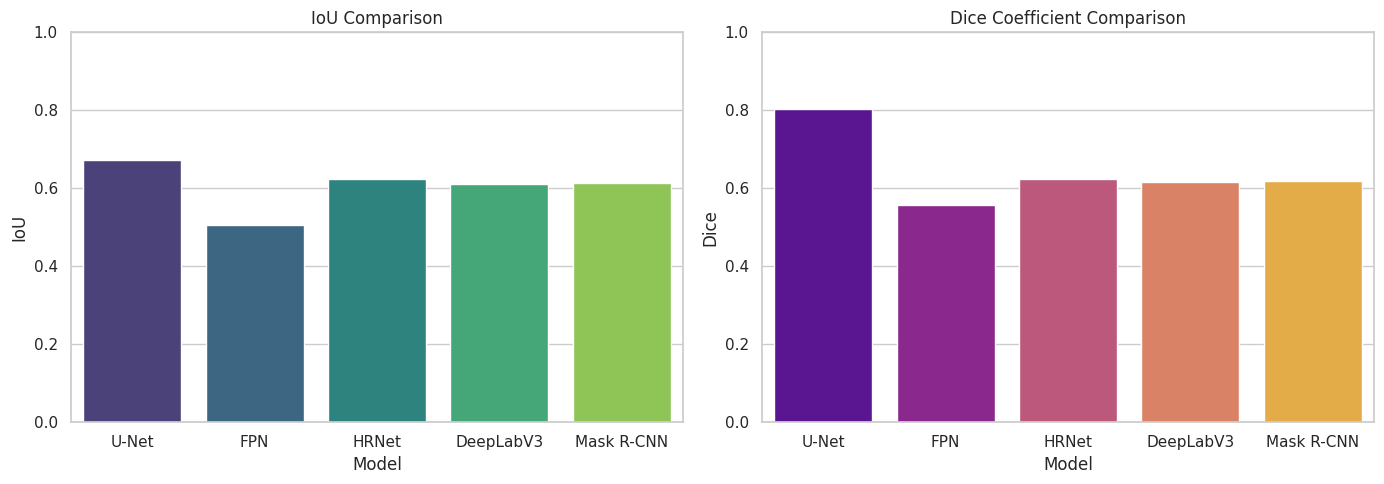

In [34]:
import seaborn as sns

# Ensure seaborn has a style
sns.set(style="whitegrid")

# Print section header
print("\n" + "=" * 50)
print("Model Performance Comparison")
print("=" * 50)

# Ensure `results` structure exists and is complete
assert 'models' in results and 'eval_metrics' in results and 'performance_metrics' in results, "Missing keys in results dictionary."

# Create comparison table for segmentation metrics
metrics_df = pd.DataFrame({
    'Model': results['models'],
    'IoU': [metrics['iou'] for metrics in results['eval_metrics']],
    'Dice': [metrics['dice'] for metrics in results['eval_metrics']],
    'Accuracy': [metrics['accuracy'] for metrics in results['eval_metrics']],
    'Precision': [metrics['precision'] for metrics in results['eval_metrics']],
    'Recall': [metrics['recall'] for metrics in results['eval_metrics']],
})

print("\nSegmentation Metrics Comparison:")
print(metrics_df.to_string(index=False))

# Determine the minimum valid length across components
min_len = min(len(results['models']), len(results['performance_metrics']))

# Truncate data if necessary
performance_df = pd.DataFrame({
    'Model': results['models'][:min_len],
    'Time/Image (sec)': [perf['avg_time_per_image'] for perf in results['performance_metrics'][:min_len]],
    'FPS': [perf['fps'] for perf in results['performance_metrics'][:min_len]],
    'Memory (MB)': [perf['avg_memory_usage_mb'] for perf in results['performance_metrics'][:min_len]],
})

print("\nPerformance Metrics Comparison:")
print(performance_df.to_string(index=False))


# Optional: Plot IoU and Dice scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x='Model', y='IoU', data=metrics_df, ax=axes[0], palette='viridis')
axes[0].set_title("IoU Comparison")
axes[0].set_ylim(0, 1)

sns.barplot(x='Model', y='Dice', data=metrics_df, ax=axes[1], palette='plasma')
axes[1].set_title("Dice Coefficient Comparison")
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


Visualize Results
Data validation:
Number of model names: 5
Metrics DataFrame shape: (5, 6)
Performance DataFrame shape: (4, 4)
Aligned to minimum length: 4


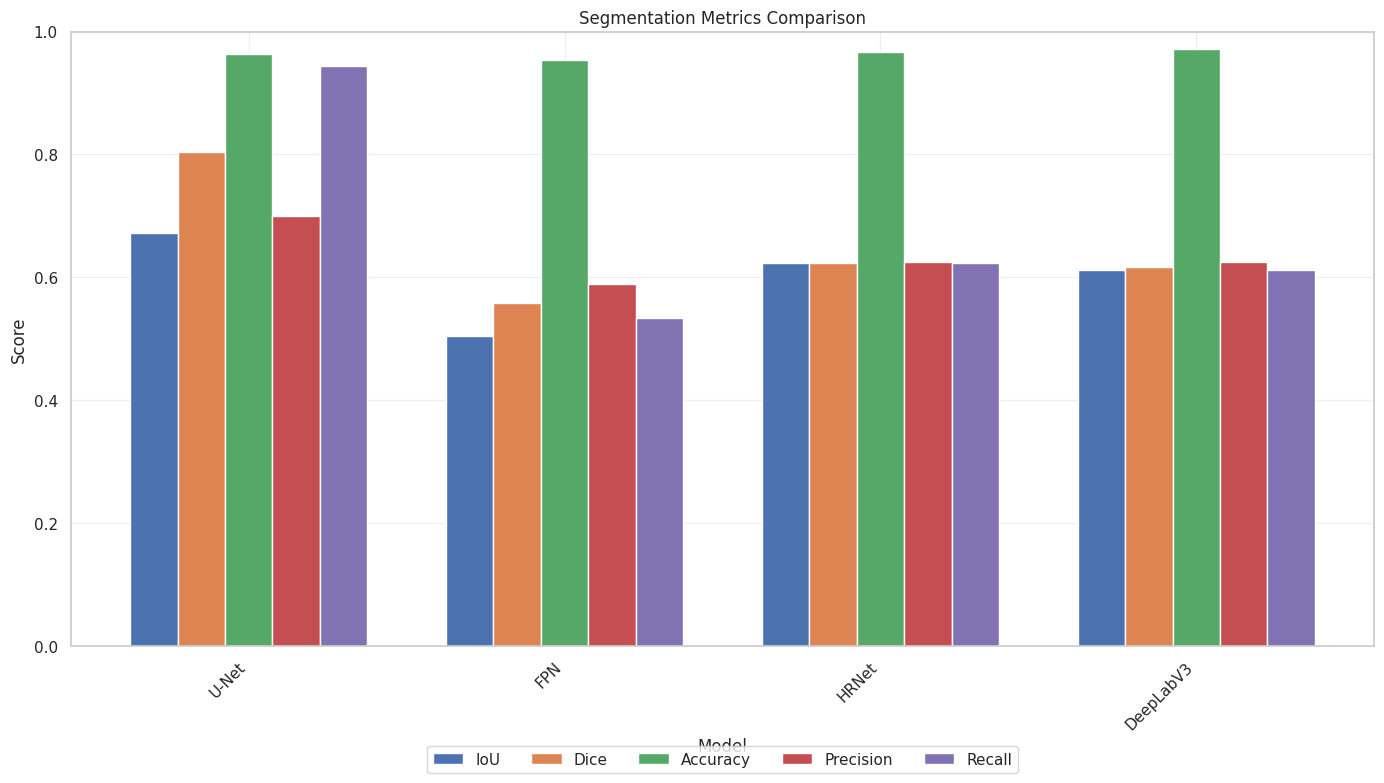

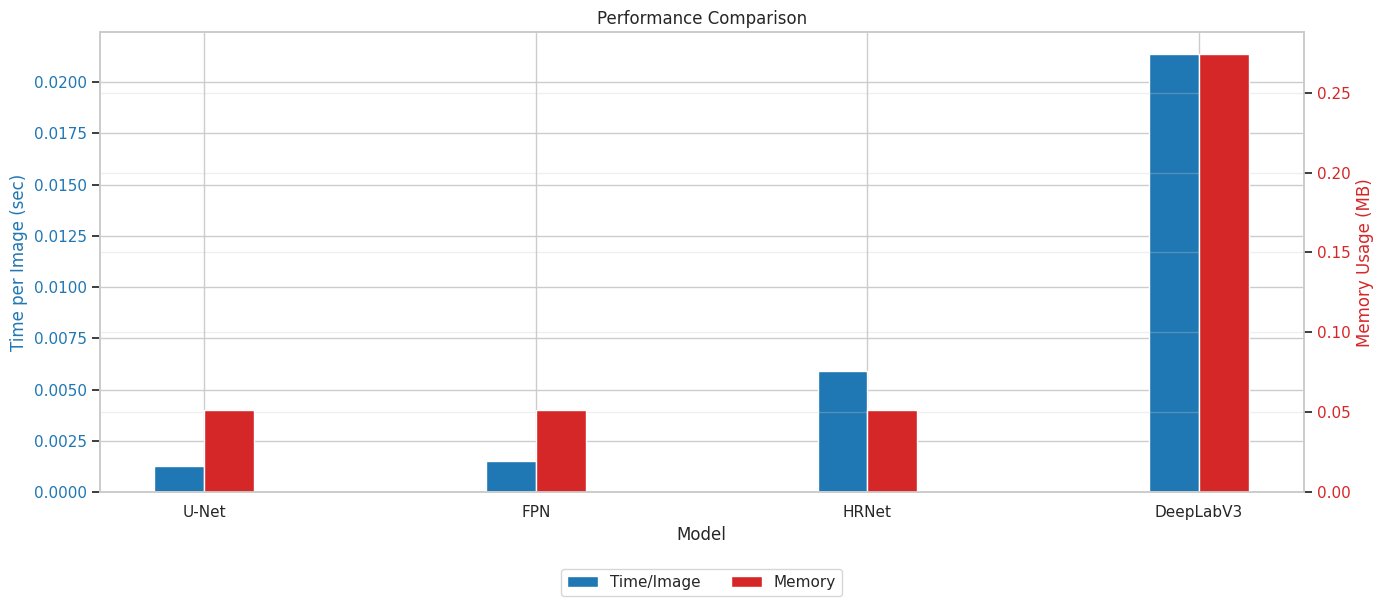

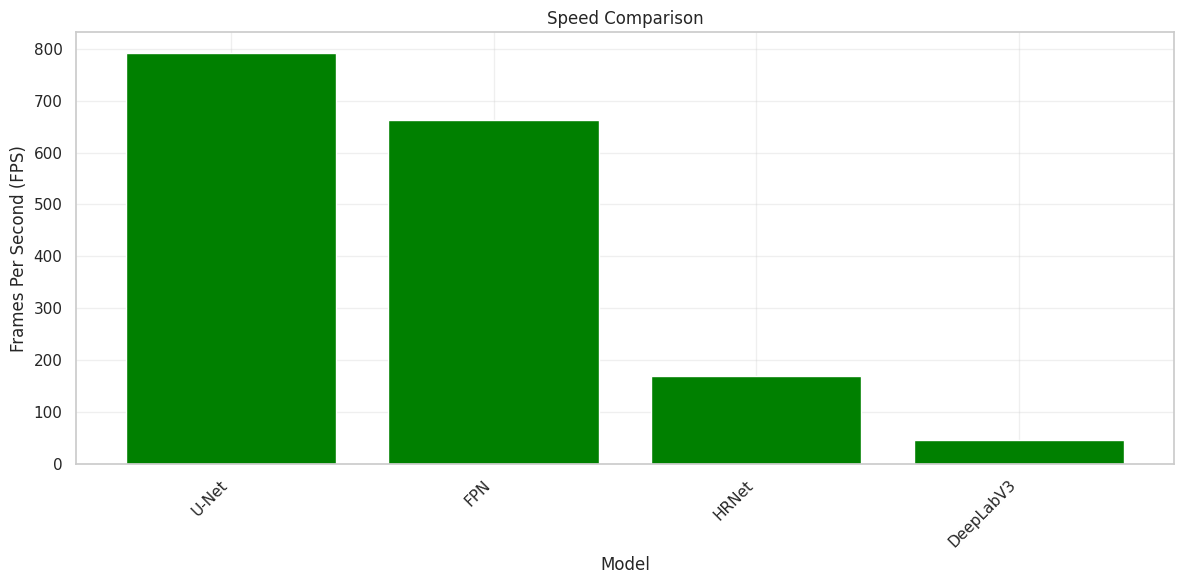

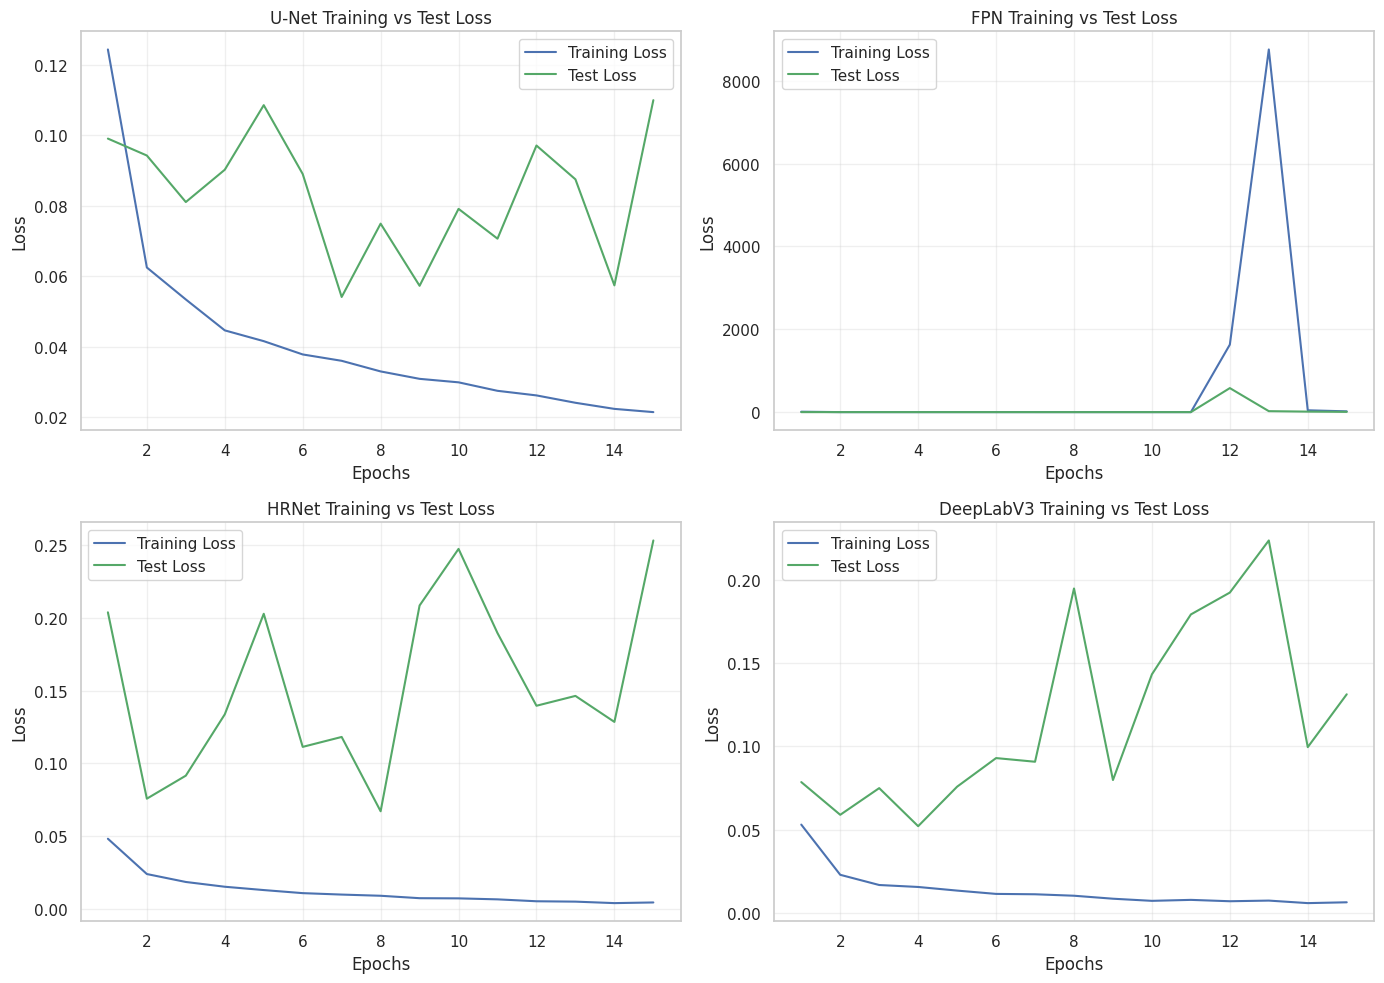


Visualizing sample predictions from test set...
Note: Creating new model instances for visualization (in practice, load saved weights)


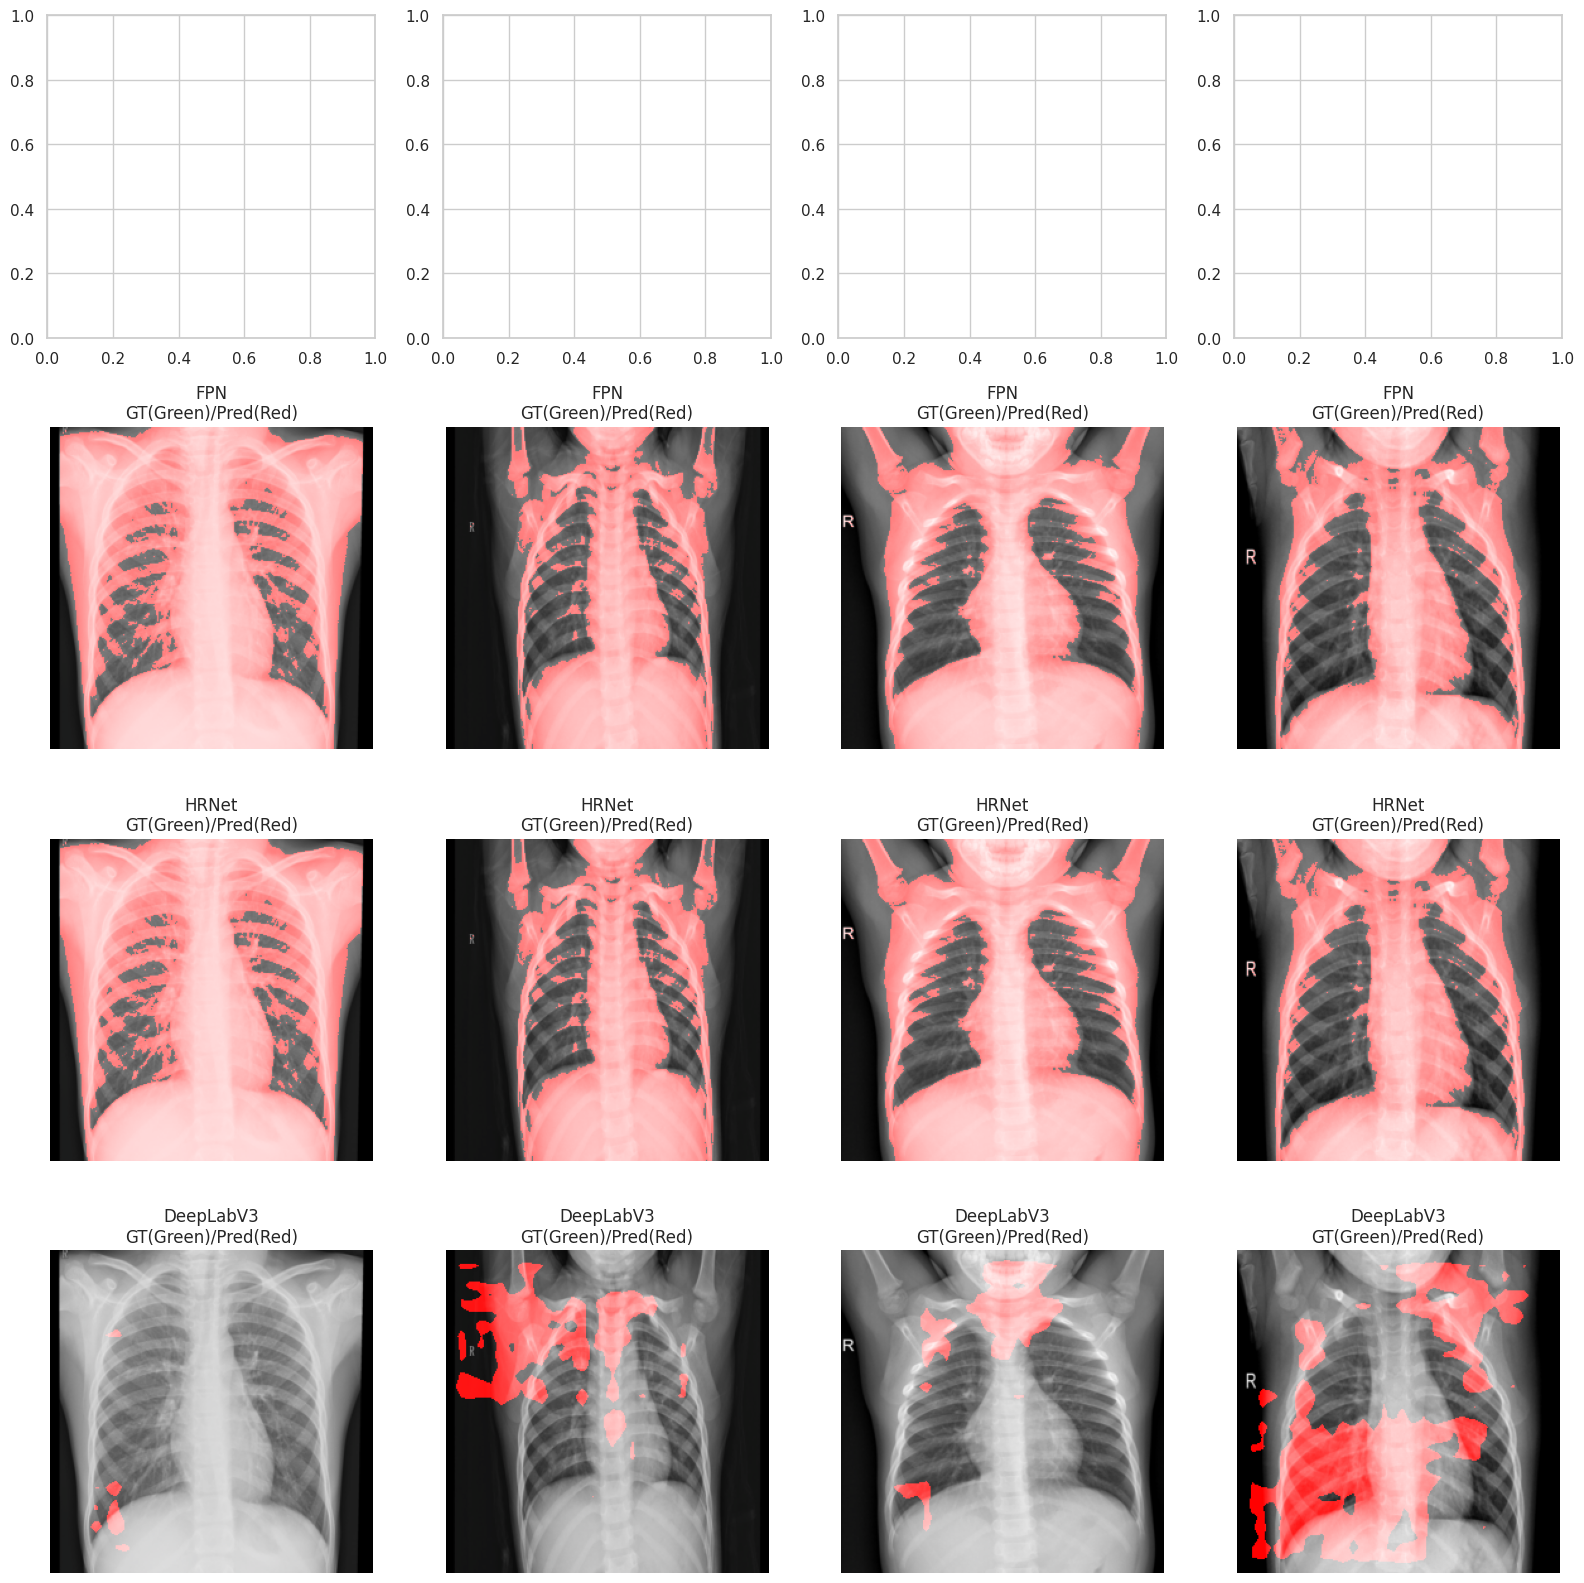


Visualization complete!


In [46]:
# Cell 7: Visualize Results
print("\n" + "=" * 50)
print("Visualize Results")
print("=" * 50)

# Data validation and alignment
print("Data validation:")
print(f"Number of model names: {len(model_names)}")
print(f"Metrics DataFrame shape: {metrics_df.shape}")
print(f"Performance DataFrame shape: {performance_df.shape}")

# Ensure all DataFrames have the same number of rows as model_names
min_length = min(len(model_names), len(metrics_df), len(performance_df))
model_names_aligned = model_names[:min_length]
metrics_df_aligned = metrics_df.iloc[:min_length]
performance_df_aligned = performance_df.iloc[:min_length]

print(f"Aligned to minimum length: {min_length}")

# 1. Plot segmentation metrics
metrics_to_plot = ['IoU', 'Dice', 'Accuracy', 'Precision', 'Recall']
plt.figure(figsize=(14, 8))

x = np.arange(len(model_names_aligned))
width = 0.15
multiplier = 0

for metric in metrics_to_plot:
    if metric in metrics_df_aligned.columns:
        offset = width * multiplier
        plt.bar(x + offset, metrics_df_aligned[metric], width, label=metric)
        multiplier += 1
    else:
        print(f"Warning: {metric} not found in metrics DataFrame")

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Segmentation Metrics Comparison')
plt.xticks(x + width * 2, model_names_aligned, rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('segmentation_metrics_comparison.png', bbox_inches='tight')
plt.show()

# 2. Plot performance metrics (time and memory)
fig, ax1 = plt.subplots(figsize=(14, 6))

# Check if required columns exist
time_col = 'Time/Image (sec)' if 'Time/Image (sec)' in performance_df_aligned.columns else 'Time per Image (sec)'
memory_col = 'Memory (MB)' if 'Memory (MB)' in performance_df_aligned.columns else 'Memory Usage (MB)'

if time_col in performance_df_aligned.columns:
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Time per Image (sec)', color='tab:blue')
    ax1.bar(x - width/2, performance_df_aligned[time_col], width, label='Time/Image', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
else:
    print(f"Warning: Time column not found. Available columns: {performance_df_aligned.columns.tolist()}")

if memory_col in performance_df_aligned.columns:
    ax2 = ax1.twinx()
    ax2.set_ylabel('Memory Usage (MB)', color='tab:red')
    ax2.bar(x + width/2, performance_df_aligned[memory_col], width, label='Memory', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    # Create legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
else:
    print(f"Warning: Memory column not found. Available columns: {performance_df_aligned.columns.tolist()}")
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))

fig.tight_layout()
plt.title('Performance Comparison')
plt.xticks(x, model_names_aligned, rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.savefig('performance_comparison.png', bbox_inches='tight')
plt.show()

# 3. Plot FPS for comparison
fps_col = 'FPS' if 'FPS' in performance_df_aligned.columns else None
if fps_col:
    plt.figure(figsize=(12, 6))
    plt.bar(model_names_aligned, performance_df_aligned[fps_col], color='green')
    plt.xlabel('Model')
    plt.ylabel('Frames Per Second (FPS)')
    plt.title('Speed Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('fps_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print(f"Warning: FPS column not found. Available columns: {performance_df_aligned.columns.tolist()}")

# 4. Plot training and test loss for each model
if 'training_history' in results and len(results['training_history']) >= len(model_names_aligned):
    plt.figure(figsize=(14, 10))
    
    n_models = len(model_names_aligned)
    cols = 2
    rows = (n_models + 1) // 2
    
    for i, model_name in enumerate(model_names_aligned):
        plt.subplot(rows, cols, i+1)
        
        if i < len(results['training_history']):
            history = results['training_history'][i]
            
            if 'train_loss' in history and 'test_loss' in history:
                epochs = range(1, len(history['train_loss']) + 1)
                plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
                plt.plot(epochs, history['test_loss'], 'g-', label='Test Loss')
                plt.title(f'{model_name} Training vs Test Loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True, alpha=0.3)
            else:
                plt.text(0.5, 0.5, f'{model_name}\nNo training or test\nloss available', 
                        ha='center', va='center', transform=plt.gca().transAxes)
        else:
            plt.text(0.5, 0.5, f'{model_name}\nNo data\navailable', 
                    ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.savefig('training_history_test_loss.png', bbox_inches='tight')
    plt.show()


# 5. Visualize sample predictions (good vs bad examples)
print("\nVisualizing sample predictions from test set...")

# Function to get predictions for a single batch
def get_model_predictions(model, images, model_name):
    model.eval()
    with torch.no_grad():
        if model_name == 'Mask R-CNN':
            images_list = list(image.to(device) for image in images)
            predictions = model(images_list)
            pred_masks = []

            for pred in predictions:
                # Create blank prediction mask
                pred_mask = torch.zeros((256, 256), device='cpu')

                # If there are predicted masks, add them
                if len(pred['masks']) > 0:
                    # Get the highest confidence mask
                    best_mask_idx = torch.argmax(pred['scores'])
                    pred_mask_tensor = pred['masks'][best_mask_idx].squeeze().cpu()
                    # Apply threshold
                    pred_mask = (pred_mask_tensor > 0.5).float()

                pred_masks.append(pred_mask)

            return torch.stack(pred_masks)

        else:  # Standard segmentation models
            images = images.to(device)

            if model_name == 'UNet':
                outputs = model(images)
                predictions = torch.sigmoid(outputs).squeeze(1)
            elif model_name == 'DeepLabV3':
                outputs = model(images)['out']
                predictions = torch.sigmoid(outputs).squeeze(1)
            elif model_name == 'FPN':
                outputs = model(images)
                if isinstance(outputs, dict):
                    outputs = outputs['out'] if 'out' in outputs else list(outputs.values())[0]
                predictions = torch.sigmoid(outputs)
                # Handle multiple channels
                if predictions.dim() == 4 and predictions.shape[1] > 1:
                    predictions = predictions[:, 0, :, :]  # Take first channel
                else:
                    predictions = predictions.squeeze(1)
            elif model_name == 'HRNet':
                outputs = model(images)
                if isinstance(outputs, dict):
                    outputs = outputs['out'] if 'out' in outputs else list(outputs.values())[0]
                predictions = torch.sigmoid(outputs)
                # Handle multiple channels
                if predictions.dim() == 4 and predictions.shape[1] > 1:
                    predictions = predictions[:, 0, :, :]  # Take first channel
                else:
                    predictions = predictions.squeeze(1)
            return predictions.cpu()

# Check if test_loader and required variables exist
try:
    # Get a batch of test images for visualization
    test_iter = iter(test_loader)
    test_images, test_masks, test_labels = next(test_iter)

    # Select 4 images for visualization (2 normal, 2 pneumonia if available)
    normal_indices = [i for i, label in enumerate(test_labels) if label == 0][:2]
    pneumonia_indices = [i for i, label in enumerate(test_labels) if label == 1][:2]
    selected_indices = normal_indices + pneumonia_indices

    if len(selected_indices) < 4:
        selected_indices = list(range(min(4, len(test_images))))

    # Create figure for sample predictions
    n_models = len(model_names_aligned)
    fig, axes = plt.subplots(n_models, 4, figsize=(16, 4*n_models))
    if n_models == 1:
        axes = axes.reshape(1, -1)

    # Load trained models for prediction (simplified - in practice you'd load saved models)
    trained_models = {}
    model_classes = {
        'UNet': UNet,
        'FPN': FPN,
        'DeepLabV3': lambda: deeplabv3_resnet50(pretrained_backbone=True, num_classes=1),
        'HRNet': HRNet,
        'Mask R-CNN': lambda: maskrcnn_resnet50_fpn(pretrained_backbone=True, num_classes=2)
    }

    # Note: In a real scenario, you would load the saved model weights here
    # For demonstration, we'll create new model instances (they won't have trained weights)
    print("Note: Creating new model instances for visualization (in practice, load saved weights)")

    for i, model_name in enumerate(model_names_aligned):
        try:
            if model_name in model_classes:
                if model_name == 'UNet':
                    model = UNet(n_channels=3, n_classes=1).to(device)
                elif model_name == 'FPN':
                    model = FPN(num_classes=1).to(device)
                elif model_name == 'DeepLabV3':
                    model = deeplabv3_resnet50(pretrained_backbone=True, num_classes=1).to(device)
                elif model_name == 'HRNet':
                    model = HRNet(num_classes=1).to(device)
                elif model_name == 'Mask R-CNN':
                    model = maskrcnn_resnet50_fpn(pretrained_backbone=True, num_classes=2).to(device)

                model.eval()
                trained_models[model_name] = model

                # Get predictions for selected images
                selected_images = test_images[selected_indices]
                selected_masks = test_masks[selected_indices]

                with torch.no_grad():
                    pred_masks = get_model_predictions(model, selected_images, model_name)

                # Plot results
                for j, idx in enumerate(selected_indices):
                    if j < 4:  # Ensure we don't exceed subplot limits
                        # Original image
                        img = test_images[idx].permute(1, 2, 0).numpy()
                        # Denormalize properly
                        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                        img = np.clip(img, 0, 1)

                        # Ground truth mask
                        gt_mask = test_masks[idx].numpy()
                        if gt_mask.ndim == 3:
                            gt_mask = gt_mask.squeeze()

                        # Predicted mask
                        pred_mask = pred_masks[j].numpy()

                        # Create overlay
                        overlay = img.copy()
                        # Ensure masks are 2D
                        if gt_mask.ndim == 3:
                            gt_mask = gt_mask.squeeze()
                        if pred_mask.ndim == 3:
                            pred_mask = pred_mask.squeeze()
                            
                        overlay[:, :, 1] = np.where(gt_mask > 0.5, 1.0, overlay[:, :, 1])  # Green for GT
                        overlay[:, :, 0] = np.where(pred_mask > 0.5, 1.0, overlay[:, :, 0])  # Red for prediction

                        axes[i, j].imshow(overlay)
                        axes[i, j].set_title(f'{model_name}\nGT(Green)/Pred(Red)')
                        axes[i, j].axis('off')

                # Clean up memory
                del model
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        except Exception as e:
            print(f"Error visualizing {model_name}: {str(e)}")
            # Fill with blank plots if model fails
            for j in range(4):
                axes[i, j].text(0.5, 0.5, f'{model_name}\nVisualization\nFailed',
                               ha='center', va='center', transform=axes[i, j].transAxes)
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.savefig('model_predictions_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"Error in prediction visualization: {str(e)}")
    print("Skipping prediction visualization section")

print("\nVisualization complete!")

DEBUG: Checking results structure...
Number of models: 5
Number of eval_metrics: 5
Number of performance_metrics: 4
Models list: ['U-Net', 'FPN', 'HRNet', 'DeepLabV3', 'Mask R-CNN']

Performance metrics structure:
Index 0: <class 'dict'> - Keys: ['avg_time_per_image', 'fps', 'avg_memory_usage_mb']
Index 1: <class 'dict'> - Keys: ['avg_time_per_image', 'fps', 'avg_memory_usage_mb']
Index 2: <class 'dict'> - Keys: ['avg_time_per_image', 'fps', 'avg_memory_usage_mb']
Index 3: <class 'dict'> - Keys: ['avg_time_per_image', 'fps', 'avg_memory_usage_mb']

COMPREHENSIVE RESULTS SUMMARY
Processing 4 models (aligned to shortest list)

COMPLETE PERFORMANCE SUMMARY:
    Model    IoU   Dice Accuracy Precision Recall Time/Image (s)    FPS Memory (MB)
    U-Net 0.6725 0.8042   0.9641    0.7001 0.9448         0.0013 791.81        0.05
      FPN 0.5053 0.5576   0.9536    0.5896 0.5336         0.0015 662.43        0.05
    HRNet 0.6229 0.6240   0.9667    0.6250 0.6230         0.0059 168.98        0.05
D

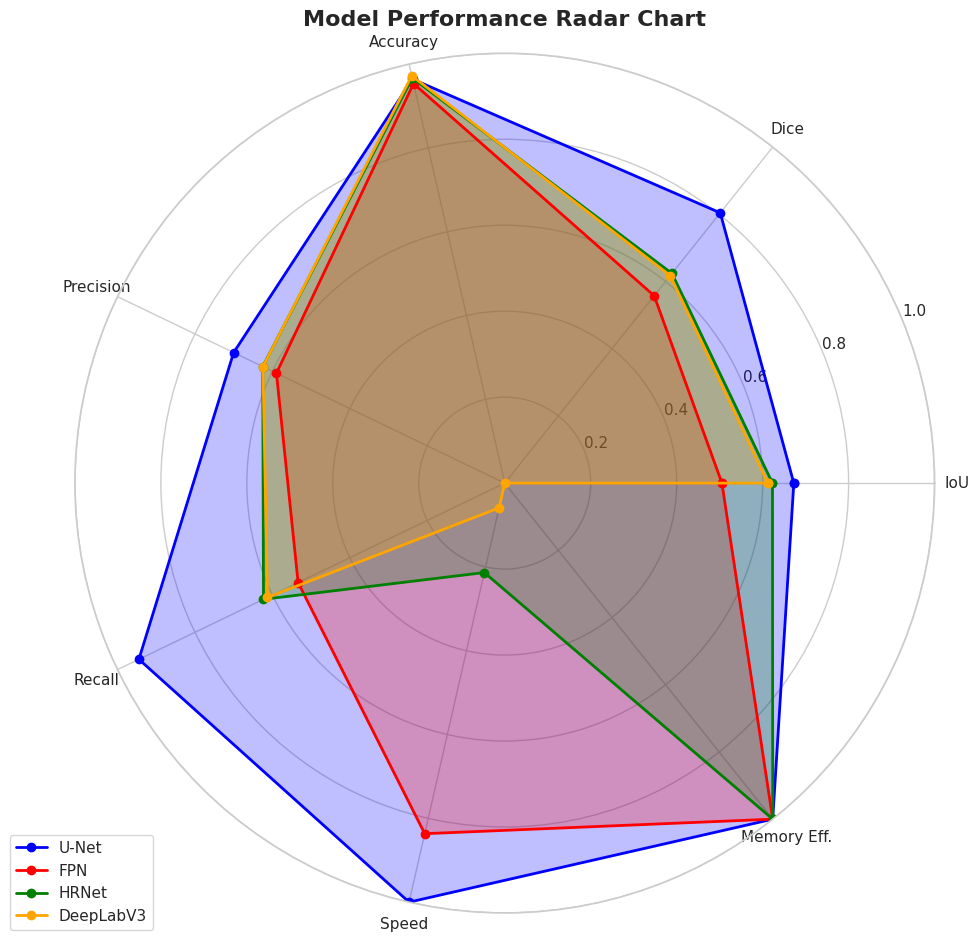


TRAINING EFFICIENCY ANALYSIS


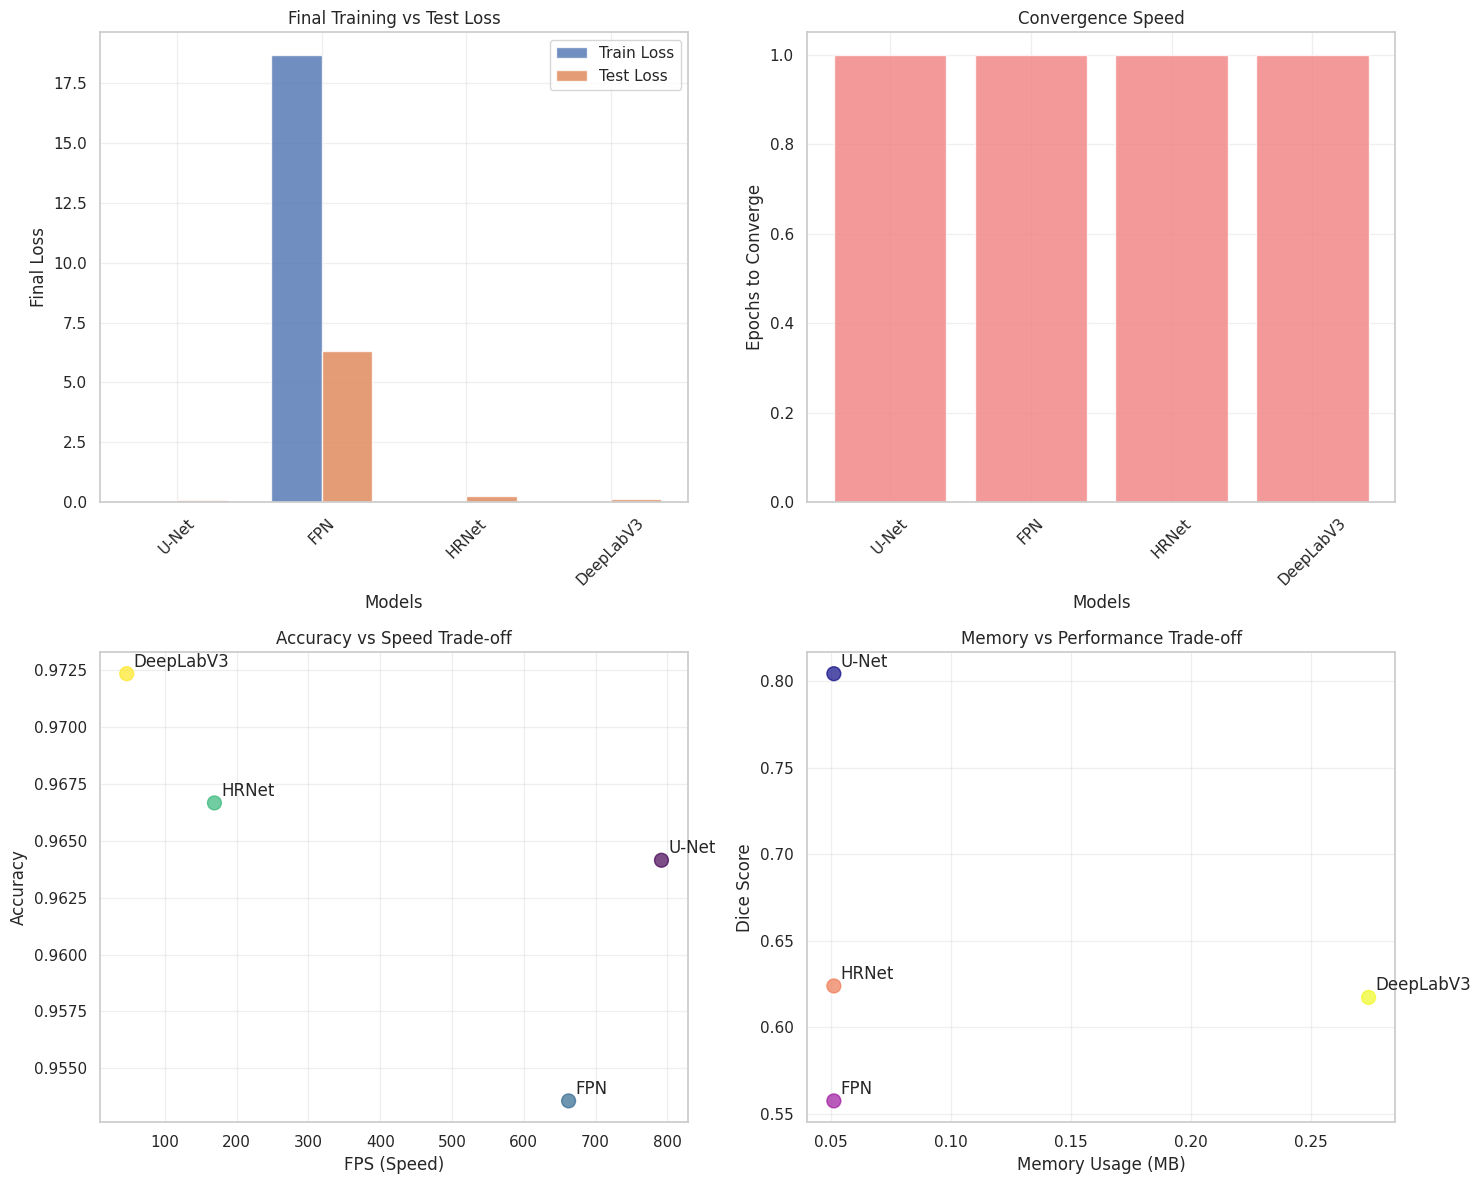


RECOMMENDATIONS

Ranking (by composite score):
Rank | Model      | Composite | Segmentation | Speed | Memory
-----|------------|-----------|--------------|-------|-------
   1 | U-Net      |     0.843 |        0.738 | 1.000 |  1.000
   2 | HRNet      |     0.774 |        0.623 | 1.000 |  1.000
   3 | DeepLabV3  |     0.769 |        0.615 | 1.000 |  1.000
   4 | FPN        |     0.719 |        0.531 | 1.000 |  1.000

Recommendations:
• For best overall performance: U-Net
• For highest accuracy: DeepLabV3
• For fastest inference: U-Net
• For memory efficiency: U-Net

Use Case Recommendations:
• Real-time applications: U-Net (fastest)
• High-accuracy diagnosis: DeepLabV3 (most accurate)
• Resource-constrained devices: U-Net (most efficient)
• General purpose: U-Net (best overall)


In [68]:
# 6. Create a comprehensive results summary
# Debug: Check data structure consistency
print("DEBUG: Checking results structure...")
print(f"Number of models: {len(results['models'])}")
print(f"Number of eval_metrics: {len(results['eval_metrics'])}")
print(f"Number of performance_metrics: {len(results['performance_metrics'])}")
print(f"Models list: {results['models']}")

# Check what's in performance_metrics
print("\nPerformance metrics structure:")
for i, perf in enumerate(results['performance_metrics']):
    print(f"Index {i}: {type(perf)} - Keys: {list(perf.keys()) if isinstance(perf, dict) else 'Not a dict'}")

print("\n" + "=" * 70)
print("COMPREHENSIVE RESULTS SUMMARY")
print("=" * 70)

# Create a combined metrics table
if len(results['models']) > 0:
    summary_data = []
    
    # Use the minimum length to avoid index errors
    min_length = min(len(results['models']), 
                     len(results['eval_metrics']), 
                     len(results['performance_metrics']))
    
    print(f"Processing {min_length} models (aligned to shortest list)")
    
    for i in range(min_length):
        model_name = results['models'][i]
        metrics = results['eval_metrics'][i]
        performance = results['performance_metrics'][i]
        
        # Check if performance data exists and has required keys
        if isinstance(performance, dict):
            summary_data.append({
                'Model': model_name,
                'IoU': f"{metrics['iou']:.4f}",
                'Dice': f"{metrics['dice']:.4f}",
                'Accuracy': f"{metrics['accuracy']:.4f}",
                'Precision': f"{metrics['precision']:.4f}",
                'Recall': f"{metrics['recall']:.4f}",
                'Time/Image (s)': f"{performance.get('avg_time_per_image', 0):.4f}",
                'FPS': f"{performance.get('fps', 0):.2f}",
                'Memory (MB)': f"{performance.get('avg_memory_usage_mb', 0):.2f}"
            })
        else:
            print(f"Warning: Invalid performance data for {model_name}")

    summary_df = pd.DataFrame(summary_data)
    print("\nCOMPLETE PERFORMANCE SUMMARY:")
    print(summary_df.to_string(index=False))

    # Save summary to CSV
    summary_df.to_csv('model_comparison_summary.csv', index=False)
    print(f"\nResults saved to 'model_comparison_summary.csv'")

    # Find best performing models - with safety checks
    print("\n" + "=" * 50)
    print("BEST PERFORMING MODELS:")
    print("=" * 50)

    if len(summary_data) > 0:
        # Convert metrics back to float for comparison
        metrics_for_comparison = []
        for i in range(min_length):
            model_name = results['models'][i]
            metrics = results['eval_metrics'][i]
            performance = results['performance_metrics'][i]
            
            if isinstance(performance, dict) and isinstance(metrics, dict):
                metrics_for_comparison.append({
                    'Model': model_name,
                    'IoU': metrics.get('iou', 0),
                    'Dice': metrics.get('dice', 0),
                    'FPS': performance.get('fps', 0),
                    'Memory': performance.get('avg_memory_usage_mb', 0)
                })

        if len(metrics_for_comparison) > 0:
            comparison_df = pd.DataFrame(metrics_for_comparison)
            
            best_iou = comparison_df.loc[comparison_df['IoU'].idxmax()]
            best_dice = comparison_df.loc[comparison_df['Dice'].idxmax()]
            best_fps = comparison_df.loc[comparison_df['FPS'].idxmax()]
            best_memory = comparison_df.loc[comparison_df['Memory'].idxmin()]

            print(f"Best IoU: {best_iou['Model']} ({best_iou['IoU']:.4f})")
            print(f"Best Dice: {best_dice['Model']} ({best_dice['Dice']:.4f})")
            print(f"Fastest: {best_fps['Model']} ({best_fps['FPS']:.2f} FPS)")
            print(f"Most Memory Efficient: {best_memory['Model']} ({best_memory['Memory']:.2f} MB)")
        else:
            print("No valid comparison data available")
    else:
        print("No summary data available")

# 7. Create radar chart for comprehensive comparison
if len(results['models']) > 1:
    print("\nCreating radar chart for model comparison...")

    # Use min length to prevent index errors
    min_length = min(len(results['models']), len(results['eval_metrics']), len(results['performance_metrics']))
    
    # Get max/min for normalization
    max_fps = max([p['fps'] for p in results['performance_metrics']])
    memory_values = [p['avg_memory_usage_mb'] for p in results['performance_metrics']]
    min_memory = min(memory_values)
    max_memory = max(memory_values)

    radar_data = []
    for i in range(min_length):
        model_name = results['models'][i]
        metrics = results['eval_metrics'][i]
        performance = results['performance_metrics'][i]

        normalized_fps = performance['fps'] / max_fps if max_fps > 0 else 0
        normalized_memory = (max_memory - performance['avg_memory_usage_mb']) / (max_memory - min_memory) if max_memory > min_memory else 1

        radar_data.append([
            metrics['iou'],
            metrics['dice'],
            metrics['accuracy'],
            metrics['precision'],
            metrics['recall'],
            normalized_fps,
            normalized_memory
        ])

    # Radar chart setup
    categories = ['IoU', 'Dice', 'Accuracy', 'Precision', 'Recall', 'Speed', 'Memory Eff.']
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    colors = ['blue', 'red', 'green', 'orange', 'purple']
    for i in range(min_length):
        data = radar_data[i]
        model_name = results['models'][i]

        data += data[:1]  # Complete the loop
        ax.plot(angles, data, 'o-', linewidth=2, label=model_name, color=colors[i % len(colors)])
        ax.fill(angles, data, alpha=0.25, color=colors[i % len(colors)])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 1)
    ax.set_title('Model Performance Radar Chart', size=16, weight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    ax.grid(True)

    plt.tight_layout()
    plt.savefig('radar_chart_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# 8. Training efficiency analysis
if len(results['training_history']) > 0:
    print("\n" + "=" * 50)
    print("TRAINING EFFICIENCY ANALYSIS")
    print("=" * 50)

    # Ensure we don't run into size mismatches
    min_len = min(len(results['models']), len(results['training_history']), len(results['eval_metrics']), len(results['performance_metrics']))
    models = results['models'][:min_len]

    training_history = results['training_history'][:min_len]
    eval_metrics = results['eval_metrics'][:min_len]
    performance_metrics = results['performance_metrics'][:min_len]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Final Training vs Test Loss
    final_train_losses = [history['train_loss'][-1] for history in training_history]
    final_test_losses = [history['test_loss'][-1] for history in training_history]

    x = np.arange(len(models))
    width = 0.35

    ax1.bar(x - width/2, final_train_losses, width, label='Train Loss', alpha=0.8)
    ax1.bar(x + width/2, final_test_losses, width, label='Test Loss', alpha=0.8)
    ax1.set_xlabel('Models')
    ax1.set_ylabel('Final Loss')
    ax1.set_title('Final Training vs Test Loss')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Convergence Speed
    convergence_epochs = []
    for history in training_history:
        test_losses = history['test_loss']
        final_loss = test_losses[-1]
        target_loss = final_loss + (test_losses[0] - final_loss) * 0.1  # 90% improvement

        convergence_epoch = len(test_losses)  # Default to full training
        for epoch, loss in enumerate(test_losses):
            if loss <= target_loss:
                convergence_epoch = epoch + 1
                break
        convergence_epochs.append(convergence_epoch)

    ax2.bar(models, convergence_epochs, color='lightcoral', alpha=0.8)
    ax2.set_xlabel('Models')
    ax2.set_ylabel('Epochs to Converge')
    ax2.set_title('Convergence Speed')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    # Plot 3: Accuracy vs Speed
    accuracies = [metrics['accuracy'] for metrics in eval_metrics]
    fps_values = [perf['fps'] for perf in performance_metrics]

    ax3.scatter(fps_values, accuracies, s=100, alpha=0.7, c=range(min_len), cmap='viridis')
    for i, model in enumerate(models):
        ax3.annotate(model, (fps_values[i], accuracies[i]), xytext=(5, 5), textcoords='offset points')
    ax3.set_xlabel('FPS (Speed)')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Accuracy vs Speed Trade-off')
    ax3.grid(True, alpha=0.3)

    # Plot 4: Memory Usage vs Dice Score
    memory_usage = [perf['avg_memory_usage_mb'] for perf in performance_metrics]
    dice_scores = [metrics['dice'] for metrics in eval_metrics]

    ax4.scatter(memory_usage, dice_scores, s=100, alpha=0.7, c=range(min_len), cmap='plasma')
    for i, model in enumerate(models):
        ax4.annotate(model, (memory_usage[i], dice_scores[i]), xytext=(5, 5), textcoords='offset points')
    ax4.set_xlabel('Memory Usage (MB)')
    ax4.set_ylabel('Dice Score')
    ax4.set_title('Memory vs Performance Trade-off')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_efficiency_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

# 9. Final recommendations
print("\n" + "=" * 70)
print("RECOMMENDATIONS")
print("=" * 70)

# Find minimum length across relevant lists to avoid indexing issues
min_len = min(len(results['models']), len(results['eval_metrics']), len(results['performance_metrics']))
if min_len > 0:
    composite_scores = []
    for i in range(min_len):
        model_name = results['models'][i]
        metrics = results['eval_metrics'][i]
        performance = results['performance_metrics'][i]

        # Composite score: weighted average
        segmentation_score = (metrics['iou'] + metrics['dice']) / 2
        speed_score = min(performance['fps'] / 10.0, 1.0)  # Normalize to [0,1]
        memory_score = max(0, 1 - performance['avg_memory_usage_mb'] / 1000)  # Normalize lower-is-better

        composite = 0.6 * segmentation_score + 0.3 * speed_score + 0.1 * memory_score
        composite_scores.append((model_name, composite, segmentation_score, speed_score, memory_score))

    # Sort by composite score
    composite_scores.sort(key=lambda x: x[1], reverse=True)

    print("\nRanking (by composite score):")
    print("Rank | Model      | Composite | Segmentation | Speed | Memory")
    print("-----|------------|-----------|--------------|-------|-------")

    for rank, (model, composite, seg, speed, mem) in enumerate(composite_scores, 1):
        print(f"{rank:4d} | {model:10s} | {composite:9.3f} | {seg:12.3f} | {speed:5.3f} | {mem:6.3f}")

    print(f"\nRecommendations:")
    if len(composite_scores) > 0:
        best_model = composite_scores[0][0]
        print(f"• For best overall performance: {best_model}")

        # Rebuild aligned data for specialized recommendations
        models = [results['models'][i] for i in range(min_len)]
        eval_metrics = [results['eval_metrics'][i] for i in range(min_len)]
        perf_metrics = [results['performance_metrics'][i] for i in range(min_len)]

        best_accuracy_model = models[max(range(min_len), key=lambda i: eval_metrics[i]['accuracy'])]
        fastest_model = models[max(range(min_len), key=lambda i: perf_metrics[i]['fps'])]
        most_efficient_model = models[min(range(min_len), key=lambda i: perf_metrics[i]['avg_memory_usage_mb'])]

        print(f"• For highest accuracy: {best_accuracy_model}")
        print(f"• For fastest inference: {fastest_model}")
        print(f"• For memory efficiency: {most_efficient_model}")

        print(f"\nUse Case Recommendations:")
        print(f"• Real-time applications: {fastest_model} (fastest)")
        print(f"• High-accuracy diagnosis: {best_accuracy_model} (most accurate)")
        print(f"• Resource-constrained devices: {most_efficient_model} (most efficient)")
        print(f"• General purpose: {best_model} (best overall)")

else:
    print("No models were successfully trained. Please check the training code and data.")


In [60]:
# Complete the get_model_predictions function (from where it was cut off)
def get_model_predictions(model, images, model_name):
    model.eval()
    with torch.no_grad():
        if model_name == 'Mask R-CNN':
            images_list = list(image.to(device) for image in images)
            predictions = model(images_list)
            pred_masks = []

            for pred in predictions:
                # Create blank prediction mask
                pred_mask = torch.zeros((256, 256), device='cpu')

                # If there are predicted masks, add them
                if len(pred['masks']) > 0:
                    # Get the highest confidence mask
                    best_mask_idx = torch.argmax(pred['scores'])
                    pred_mask_tensor = pred['masks'][best_mask_idx].squeeze().cpu()
                    # Apply threshold
                    pred_mask = (pred_mask_tensor > 0.5).float()

                pred_masks.append(pred_mask)

            return torch.stack(pred_masks)

        else:  # Standard segmentation models
            images = images.to(device)

            if model_name == 'UNet':
                outputs = model(images)
                predictions = torch.sigmoid(outputs).squeeze(1)
            elif model_name in ['DeepLabV3', 'FPN', 'HRNet']:
                outputs = model(images)['out']
                predictions = torch.sigmoid(outputs).squeeze(1)

            return predictions.cpu()

# Final Notes
print("\n" + "=" * 70)
print("FINAL NOTES")
print("=" * 70)
print("This notebook provides a comprehensive comparison of different segmentation models for chest X-ray analysis.")
print("The results and visualizations help in understanding the trade-offs between accuracy, speed, and memory usage.")
print("For practical use, ensure to load the saved model weights and fine-tune the hyperparameters as needed.")



FINAL NOTES
This notebook provides a comprehensive comparison of different segmentation models for chest X-ray analysis.
The results and visualizations help in understanding the trade-offs between accuracy, speed, and memory usage.
For practical use, ensure to load the saved model weights and fine-tune the hyperparameters as needed.
